<a href="https://colab.research.google.com/github/CorentinMAG/TEXT_MINING_HP/blob/main/TEXT_MINING_HP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harry Potter books analysis

In [ ]:
# all imports

import random
import time
import pandas as pd
import numpy as np
import os
import math
import string
from sklearn.base import BaseEstimator, TransformerMixin
import re
from string import ascii_letters,punctuation,digits,whitespace
from collections import OrderedDict
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import collections
from scipy.stats import chi2_contingency 
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import pprint
from nltk.stem import WordNetLemmatizer 
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({'font.size':13})
%matplotlib notebook

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Import dataset

In [ ]:
# books path

dataset = os.path.join(os.getcwd(),'drive/MyDrive/datasets/harry_potter/books_clean')
book1 = os.path.join(dataset,'HPBook1.txt')
book2 = os.path.join(dataset,'HPBook2.txt')
book3 = os.path.join(dataset,'HPBook3.txt')
book4 = os.path.join(dataset,'HPBook4.txt')
book5 = os.path.join(dataset,'HPBook5.txt')
book6 = os.path.join(dataset,'HPBook6.txt')
book7 = os.path.join(dataset,'HPBook7.txt')

In [ ]:
# load books into dataframes

hp_1 = pd.read_table(book1,sep='@')
hp_2 = pd.read_table(book2,sep='@')
hp_3 = pd.read_table(book3,sep='@')
hp_4 = pd.read_table(book4,sep='@')
hp_5 = pd.read_table(book5,sep='@')
hp_6 = pd.read_table(book6,sep='@')
hp_7 = pd.read_table(book7,sep='@')

all_books = hp_1.append([hp_2,hp_3,hp_4,hp_5,hp_6,hp_7])
all_books = all_books.set_index(['Book','Chapter'])

In [ ]:
all_books

Text
Book Chapter                                                   
1    1        THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...
     2        THE VANISHING GLASS  Nearly ten years had pass...
     3        THE LETTERS FROM NO ONE  The escape of the Bra...
     4        THE KEEPER OF THE KEYS  BOOM. They knocked aga...
     5        DIAGON ALLEY  Harry woke early the next mornin...
...                                                         ...
7    33       Harry remained kneeling at Snape's side, simpl...
     34       Finally, the truth. Lying with his face presse...
     35       He lay facedown, listening to the silence. He ...
     36       He was flying facedown on the ground again. Th...
     37       Autumn seemed to arrive suddenly that year. Th...

[200 rows x 1 columns]

In [ ]:
word_counts = all_books['Text'].str.split().str.len().sum()

In [ ]:
print(f" Harry potter books have in total {word_counts} words")

 Harry potter books have in total 1096115 words


In [ ]:
# words frequency 

text = all_books['Text']
cv = CountVectorizer()
bow = cv.fit_transform(text)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(None), columns = ['word', 'freq'])

In [ ]:
# we remove words that appear less than 5 times in the harry potter saga

allowed_words = word_counter_df['word'][word_counter_df['freq'] > 5].to_list()
allowed_words += punctuation

## Preprocessing

Some text cleaning stages

In [ ]:
def authorized_characters(input_text):
    """
    Authorized characters
    """
    allowed_char = ascii_letters + digits + punctuation + whitespace
    return "".join([c for c in input_text if c in allowed_char])

def authorized_words(input_text):
  # we pad each punctuation token
  input_text = input_text.translate(str.maketrans({key: " {0} ".format(key) for key in punctuation}))
  input_text = input_text.split()

  return " ".join([w for w in input_text if w in allowed_words])

def remove_html(input_text):
  """
  Remove all HTML tags
  """
  return re.sub(r'<[^>]*>','',input_text).strip()

def remove_punctuation(input_text,remove_dot):
    """
    Every punctuation symbol will be replaced by a space
    """
    # we keep .
    if not remove_dot:
      punct = punctuation.replace('.','')
    else:
      punct = punctuation
    trantab = str.maketrans(punct, len(punct)*' ')  
    return input_text.translate(trantab)

def to_lower(input_text):
  """
  Lowercase text
  """
  return input_text.lower()

def remove_stopwords(input_text):
  """
  Remove stopwords
  we can add words in the whitelist 
  """
  black_list = ['mr','mrs']
  stopwords_list = stopwords.words('english')
  stopwords_list += black_list
  whitelist = []
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and (len(word) > 1 or word == '.')]
  return " ".join(clean_words) 

def stemming(input_text):
  """
  Stem the text
  """
  porter = PorterStemmer()
  words = input_text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  return " ".join(stemmed_words)

def lemmatization(input_text):
  """
  lemmatize the text
  """  
  lemmatizer = WordNetLemmatizer() 
  words = input_text.split()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(lemmatized_words)

def preprocess_pipeline(text,stem=False,lemma=True,remove_dot=True): 
  text = to_lower(text)
  text = authorized_words(text)
  text = authorized_characters(text)
  text = remove_html(text)
  text = remove_punctuation(text,remove_dot)
  text = remove_stopwords(text)
  text = lemmatization(text) if lemma else text
  text = stemming(text)  if stem else text
  return text.strip()

In [ ]:
# it is better in our case to use lemmatization than stemming
all_books['preprocessed_text'] = all_books['Text'].apply(lambda x:preprocess_pipeline(x,remove_dot=True))

In [ ]:
all_books.head()

Text                                  preprocessed_text
Book Chapter                                                                                                      
1    1        THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...  boy lived dursley number four privet drive pro...
     2        THE VANISHING GLASS  Nearly ten years had pass...  vanishing glass nearly ten year passed since d...
     3        THE LETTERS FROM NO ONE  The escape of the Bra...  letter one escape boa constrictor earned harry...
     4        THE KEEPER OF THE KEYS  BOOM. They knocked aga...  keeper key knocked dudley jerked awake cannon ...
     5        DIAGON ALLEY  Harry woke early the next mornin...  diagon alley harry woke early next morning alt...

## data visualization

In [ ]:
def print_stats(df,mode='all'):
  """
  Plot the most frequents words in the dataset 
  three levels of granularity : book, chapter, all
  """
  vocab = []

  if mode == 'chapter' or mode =='book':
    books = df.index.levels[0]
    for book in books:
      text = df.loc[book]['preprocessed_text']
      cv = CountVectorizer()
      bow = cv.fit_transform(text)
      word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
      word_counter = collections.Counter(word_freq)
      word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
      title = 'book_{}'.format(book)
      word_counter_df.plot.bar(x='word',y='freq',title=title,xlabel='words',ylabel='frequency')

      if mode =='chapter':
        chapters = df.loc[book].index
        for chapter in chapters:
          text = df.loc[book,chapter]['preprocessed_text']
          cv = CountVectorizer()
          bow = cv.fit_transform([text])
          word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
          word_counter = collections.Counter(word_freq)
          word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
          title = 'book_{} chapter_{}'.format(book,chapter)
          word_counter_df.plot.bar(x='word',y='freq',title=title,xlabel='words',ylabel='frequency')
  else:
    cv = CountVectorizer()
    bow = cv.fit_transform(all_books['preprocessed_text'])
    word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
    word_counter = collections.Counter(word_freq)
    word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
    word_counter_df.plot.bar(x='word',y='freq',title="Words frequency in Harry Potter books",xlabel='words',ylabel='frequency')

In [ ]:
# count the number of words before and after the preprocessing

pre_words = all_books['Text'].apply(lambda x:len(x.split()))
all_books['pre_words'] = pre_words
post_words = all_books['preprocessed_text'].apply(lambda x:len(x.split()))
all_books['post_words'] = post_words

In [ ]:
all_books.describe()

pre_words  post_words
count   200.000000   200.00000
mean   5480.575000  2711.32500
std    1601.797246   777.87721
min    1553.000000   837.00000
25%    4326.500000  2169.00000
50%    5494.000000  2697.50000
75%    6506.250000  3211.75000
max    9081.000000  4387.00000

In [ ]:
books = all_books.index.unique(level='Book')
books

Int64Index([1, 2, 3, 4, 5, 6, 7], dtype='int64', name='Book')

In [ ]:
# list of tuples (book,chapter)

books_chapters = all_books.index

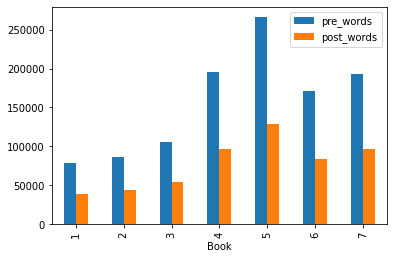

In [ ]:
# nb of words before and after preprocessing per book
words_per_book = all_books.groupby(level=0).sum()
words_per_book.groupby(level=0).sum().plot.bar()

In [ ]:
for book in books:
  pre_words,post_words = words_per_book.loc[book]
  print(f"book_{book} has {all_books.xs(book, level='Book').shape[0]} chapters, {pre_words} words before preprocessing, {post_words} words after preprocessing")

book_1 has 17 chapters, 78426 words before preprocessing, 39100 words after preprocessing
book_2 has 19 chapters, 86625 words before preprocessing, 43881 words after preprocessing
book_3 has 22 chapters, 106048 words before preprocessing, 54223 words after preprocessing
book_4 has 37 chapters, 195438 words before preprocessing, 96144 words after preprocessing
book_5 has 38 chapters, 265641 words before preprocessing, 128850 words after preprocessing
book_6 has 30 chapters, 171569 words before preprocessing, 83668 words after preprocessing
book_7 has 37 chapters, 192368 words before preprocessing, 96399 words after preprocessing


Book
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

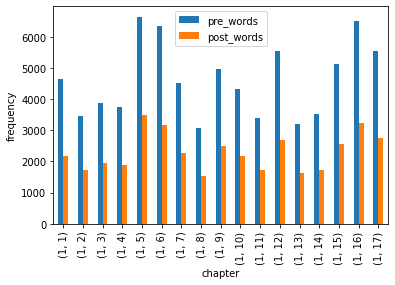

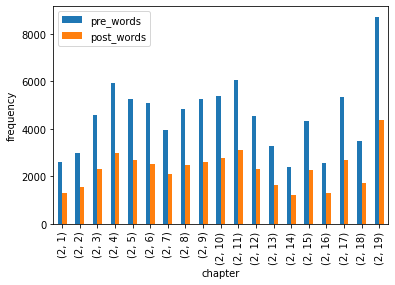

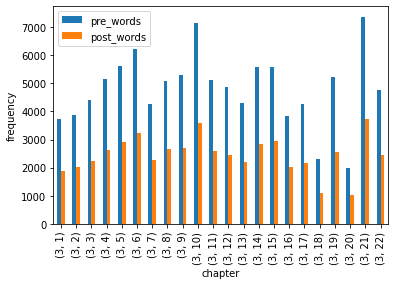

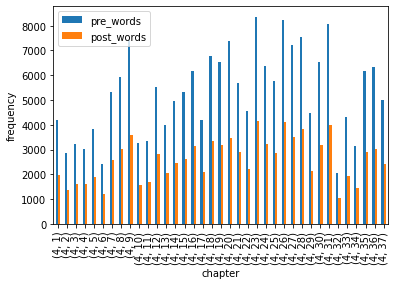

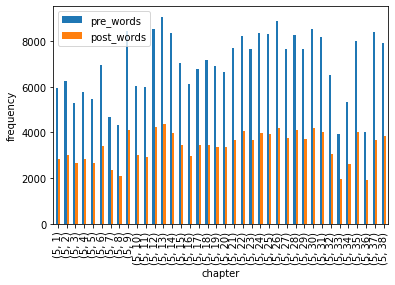

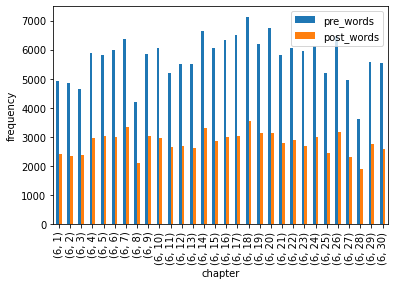

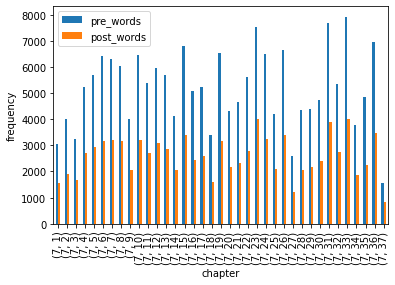

In [ ]:
# nb of words per book and per chapter

all_books.groupby(level=0).plot.bar(xlabel='chapter',ylabel='frequency')

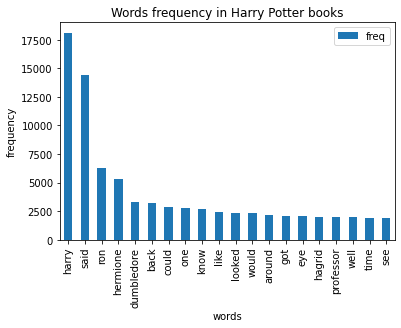

In [ ]:
print_stats(all_books)

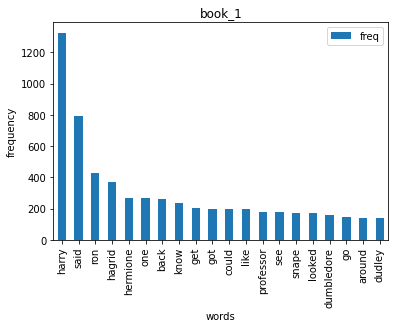

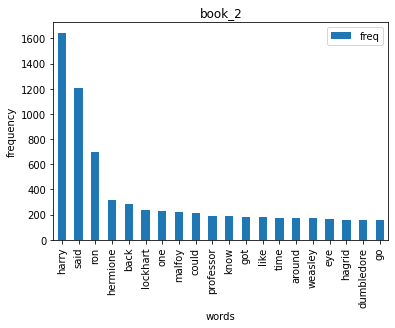

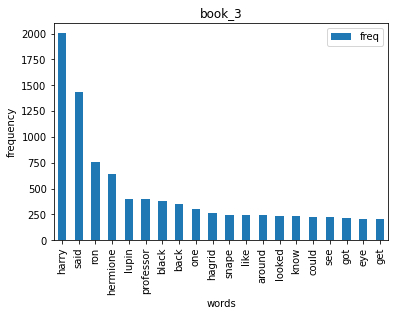

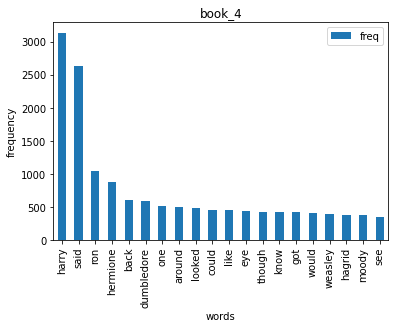

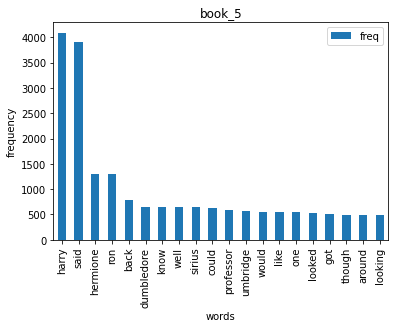

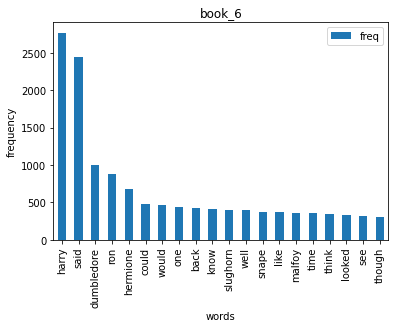

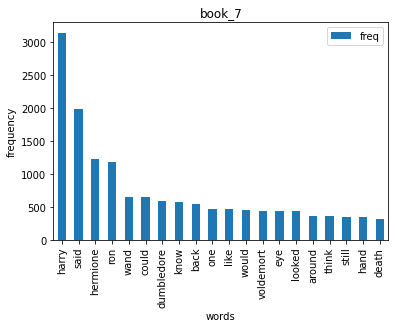

In [ ]:
print_stats(all_books,mode='book')

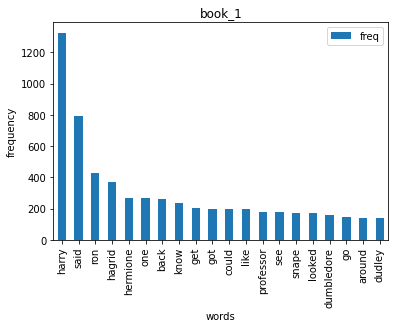

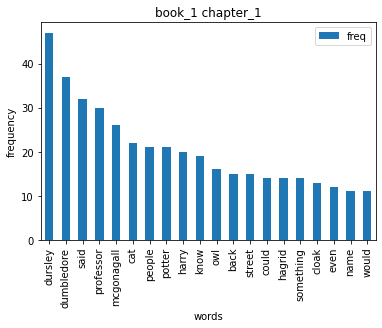

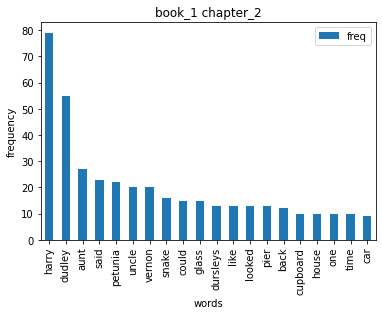

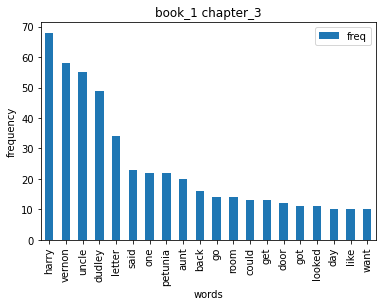

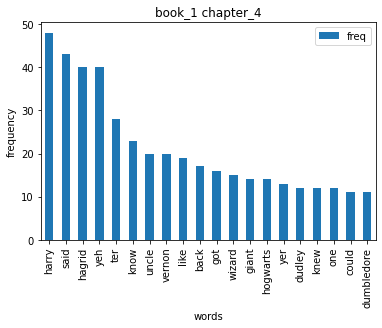

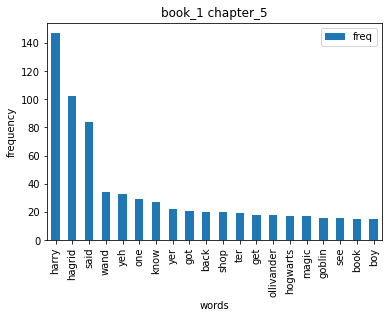

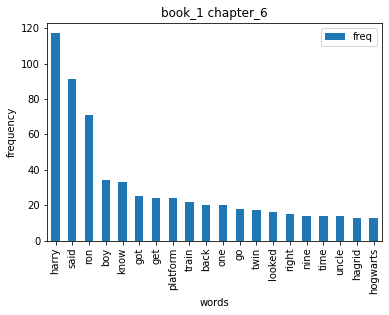

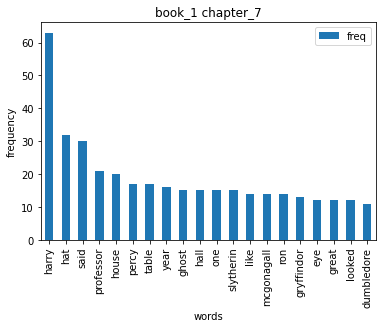

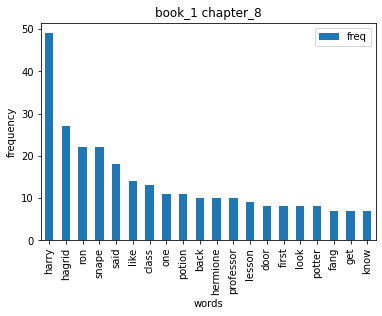

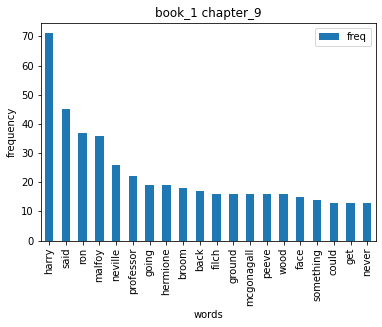

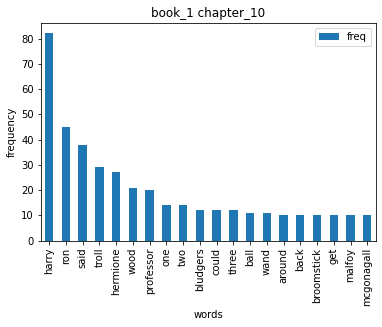

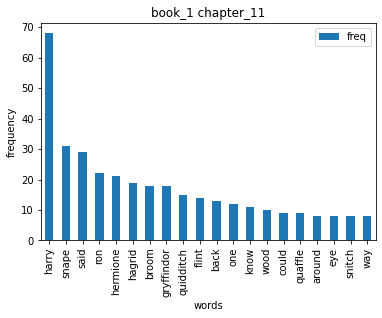

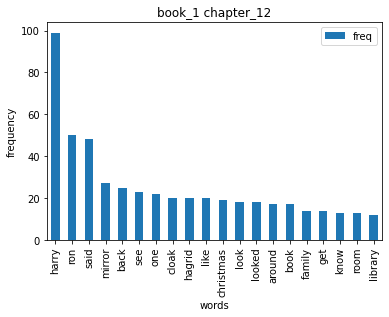

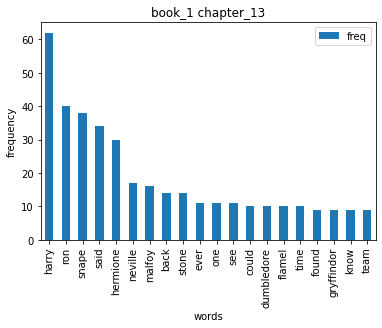

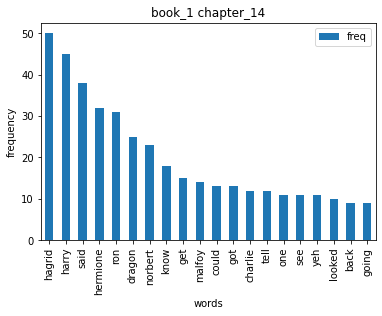

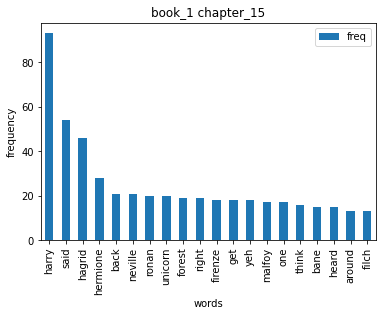

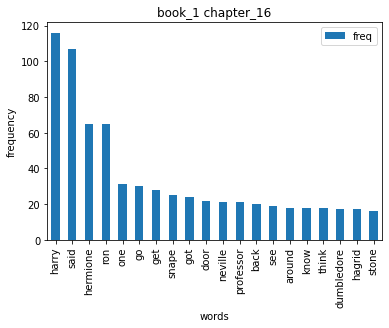

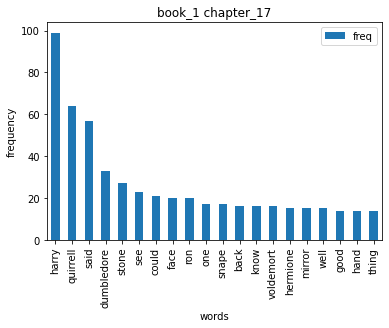

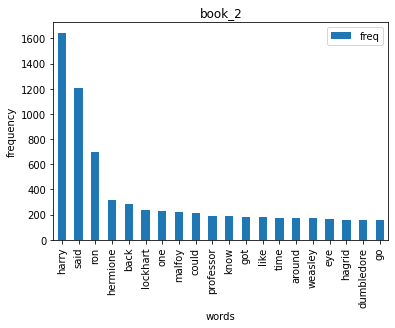

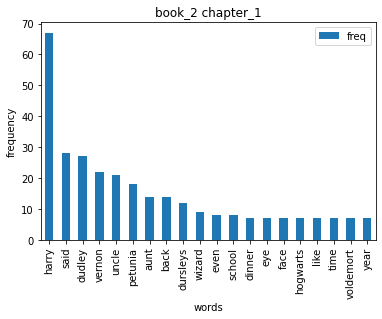

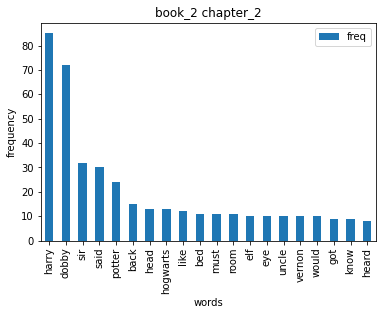

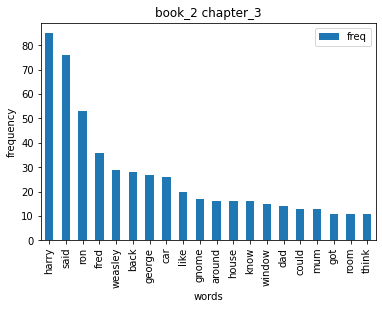

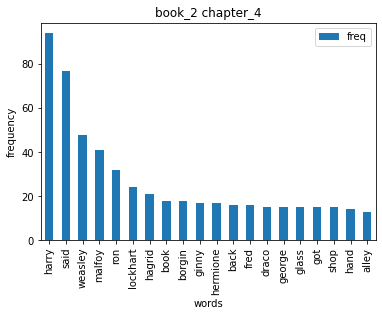

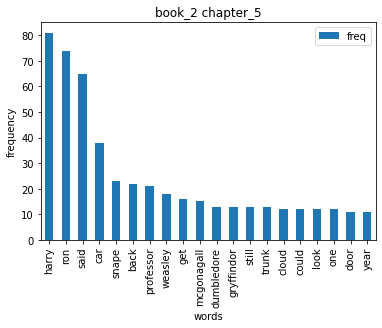

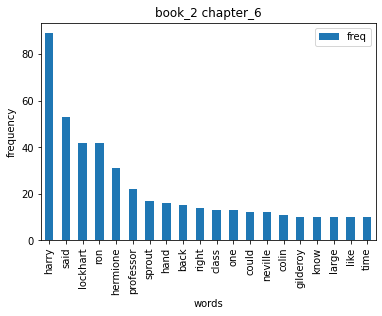

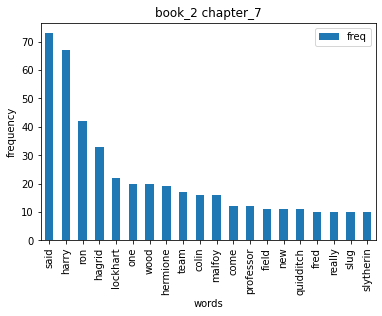

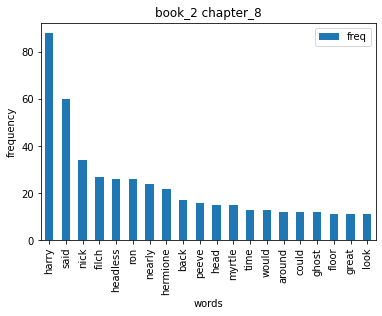

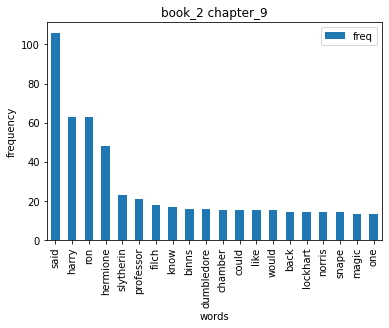

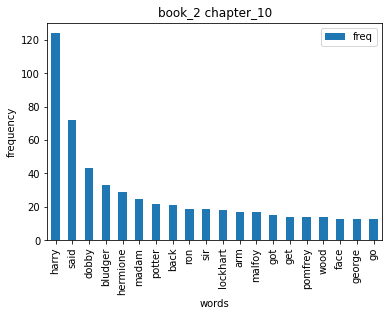

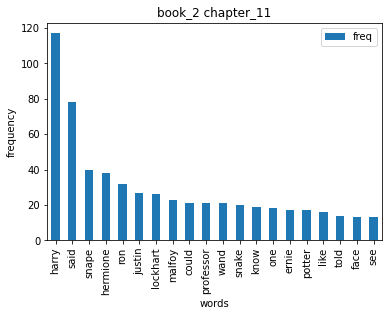

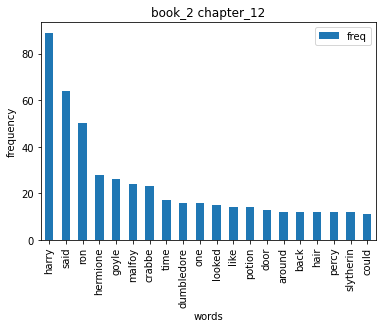

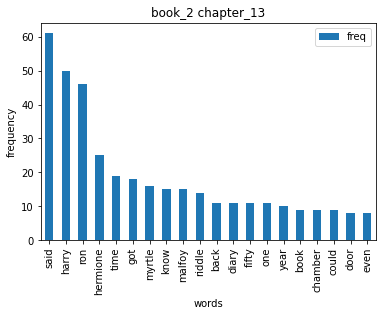

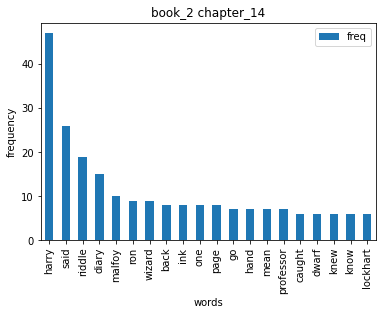

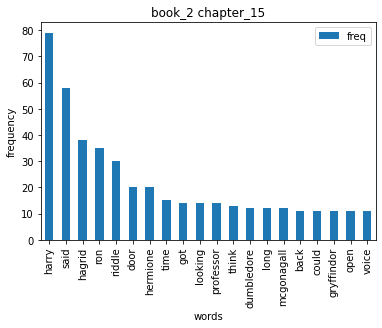

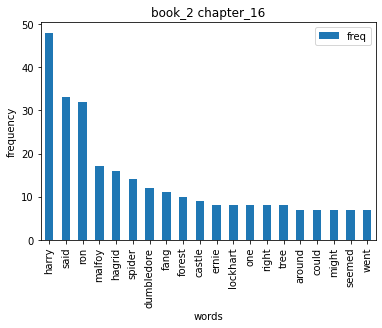

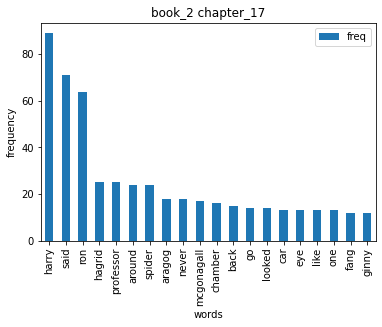

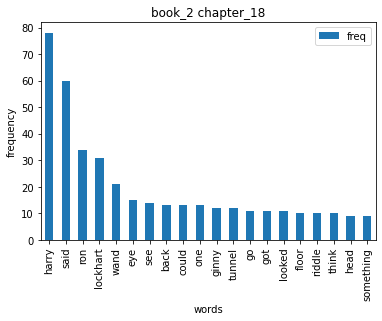

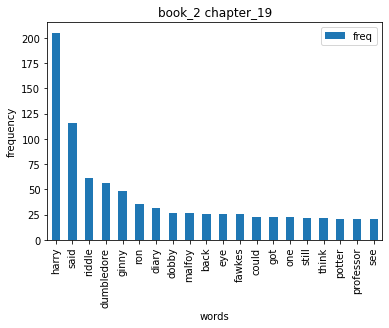

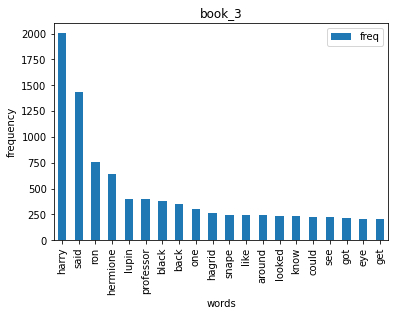

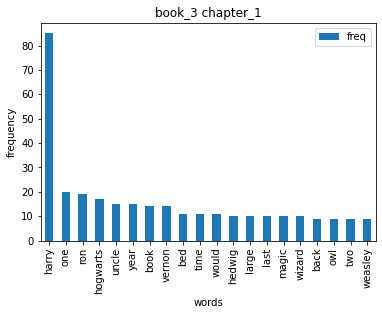

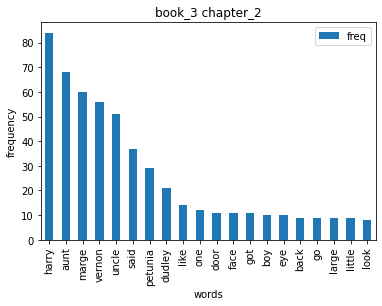

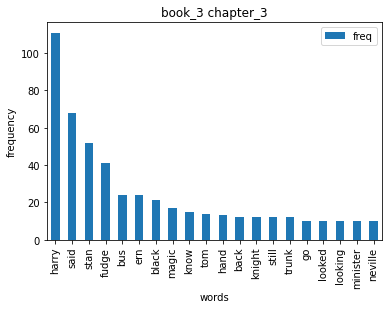

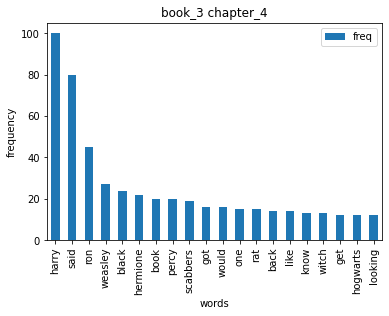

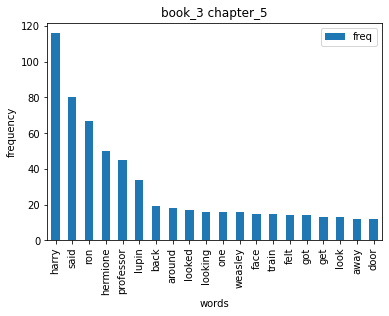

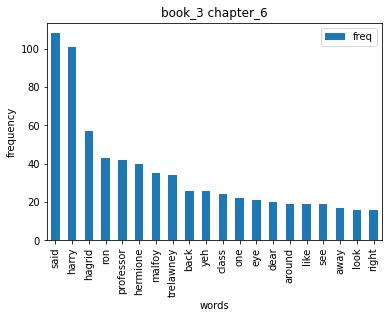

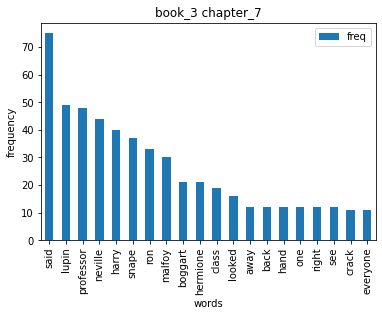

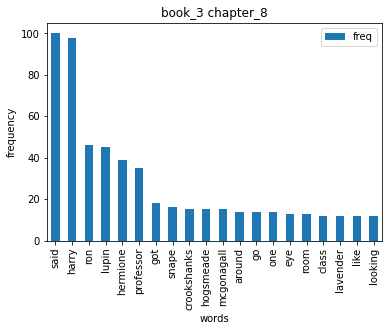

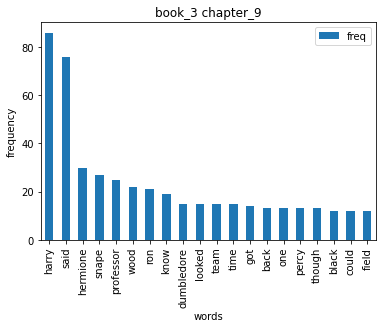

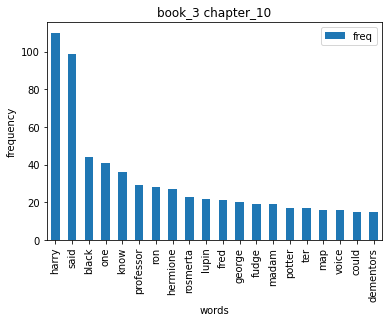

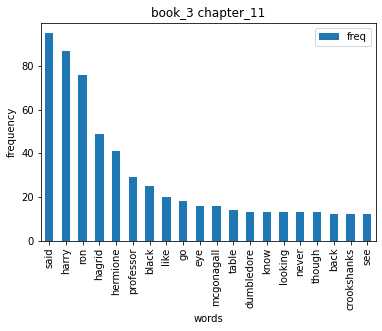

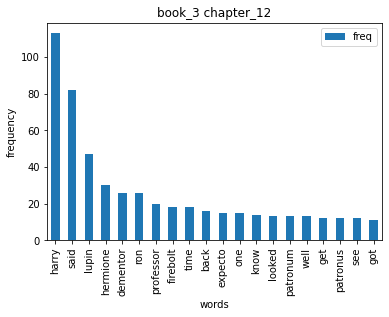

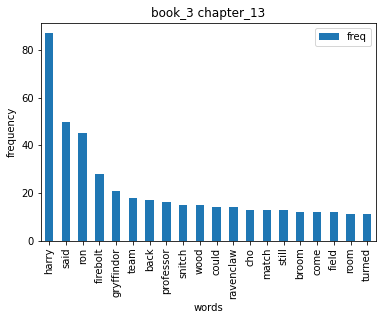

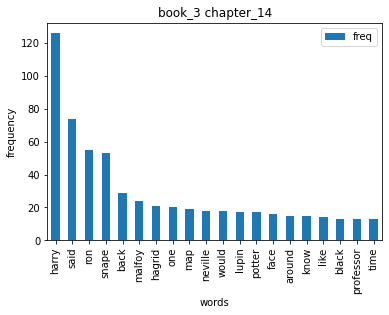

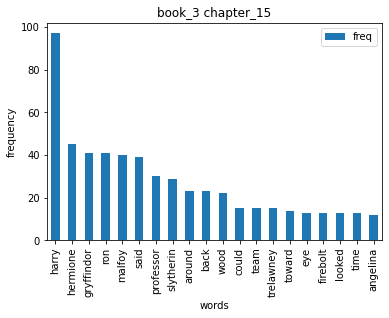

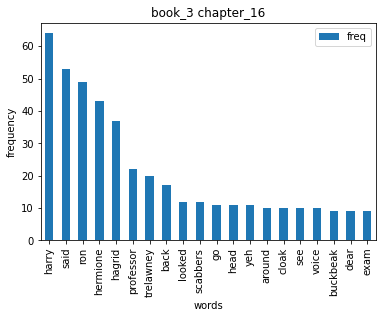

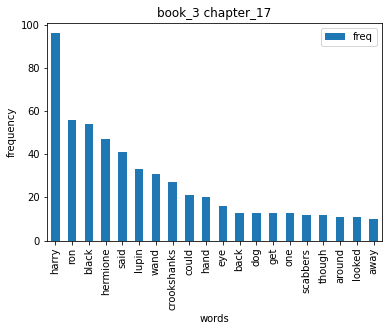

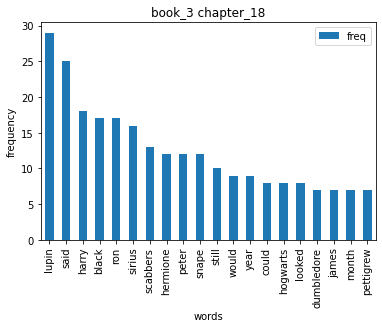

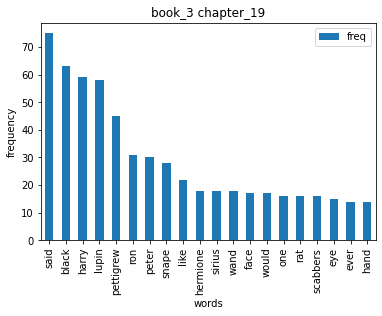

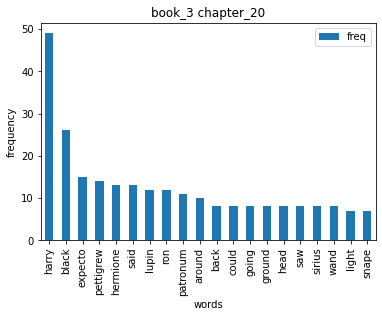

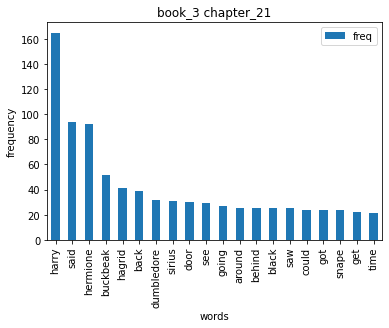

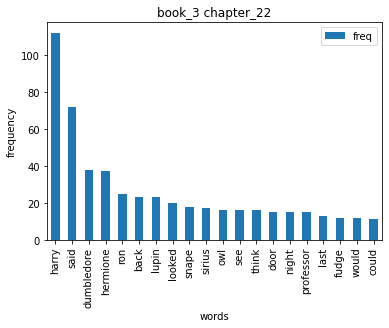

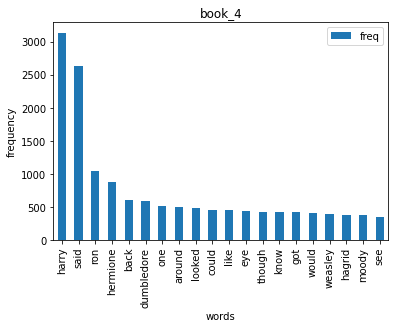

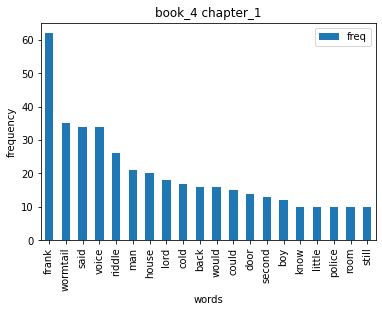

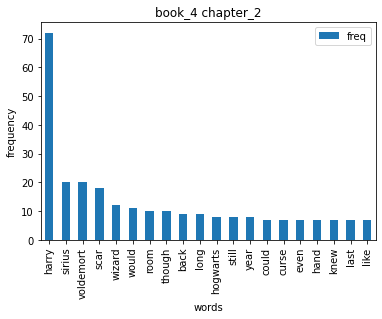

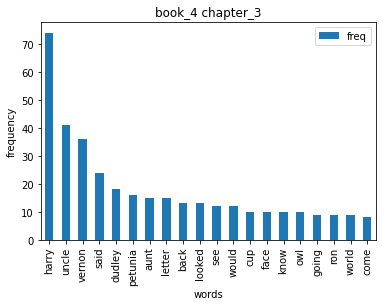

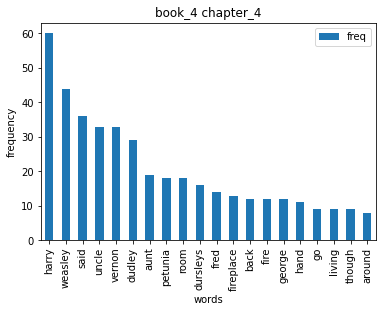

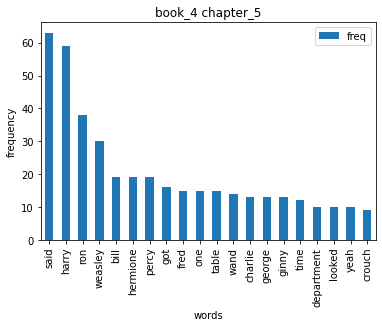

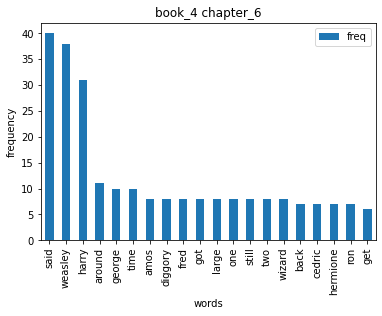

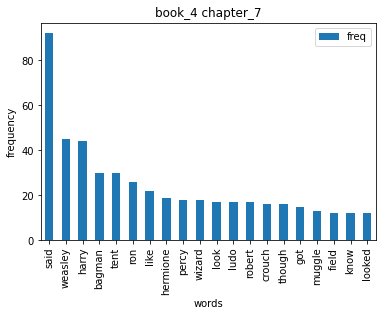

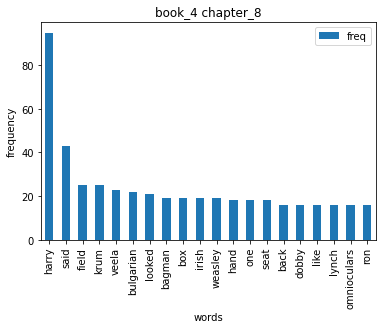

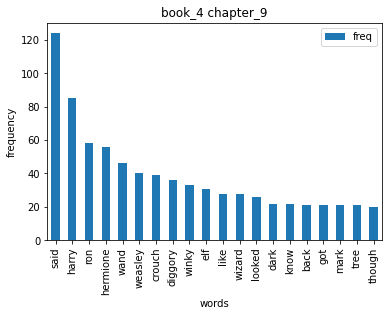

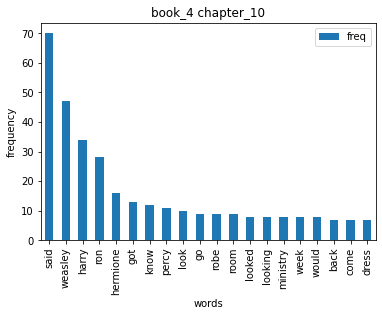

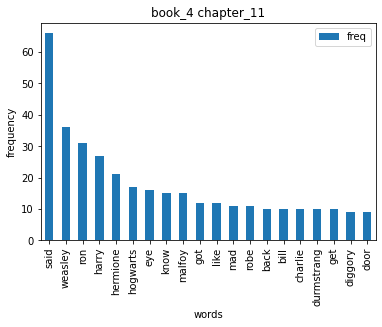

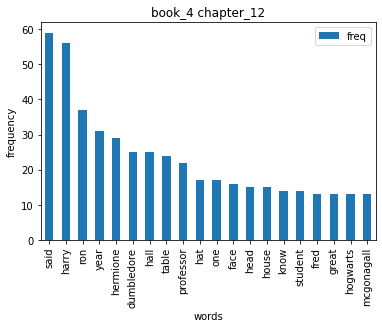

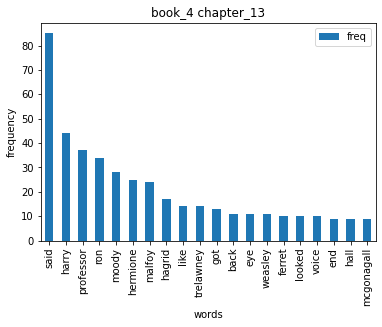

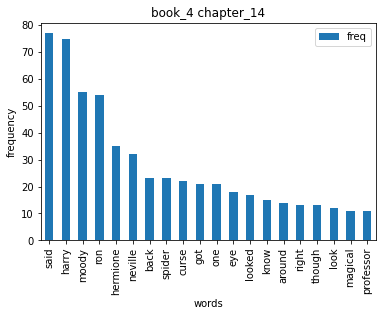

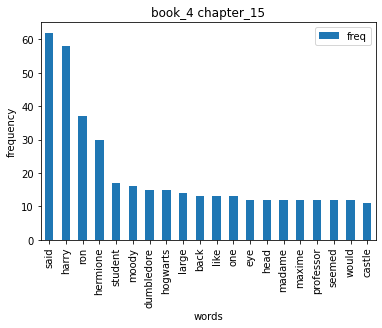

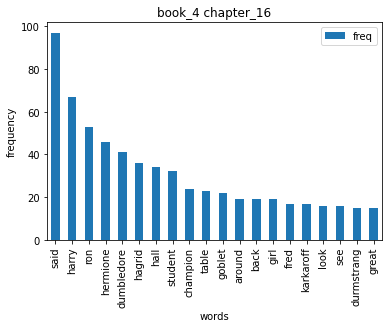

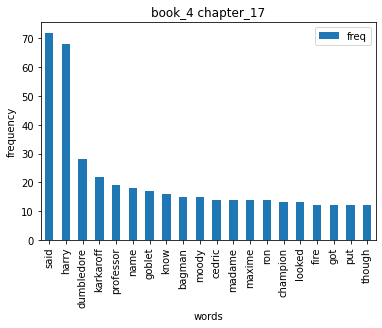

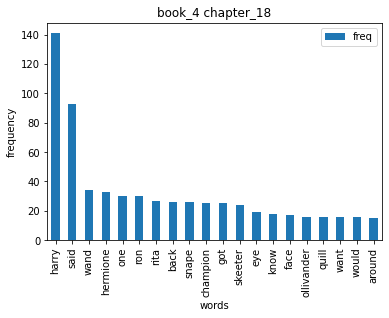

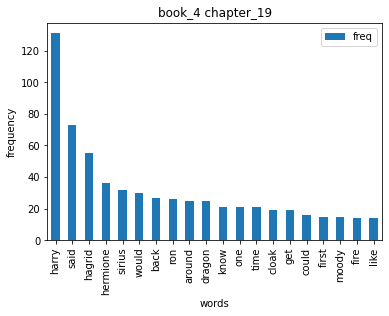

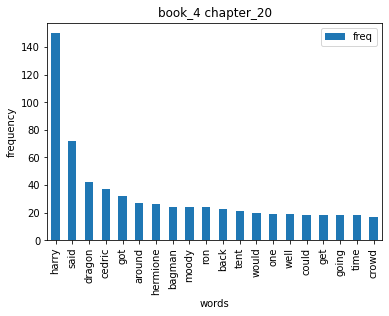

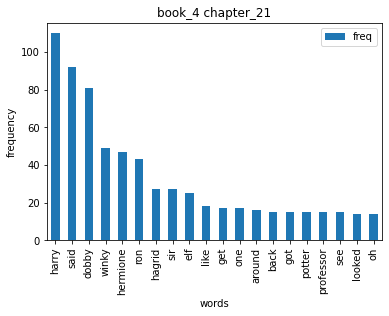

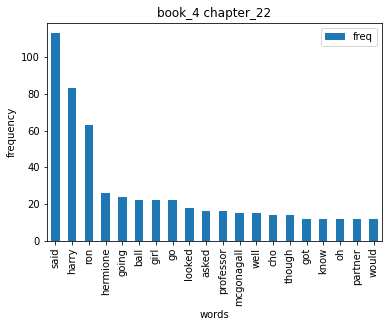

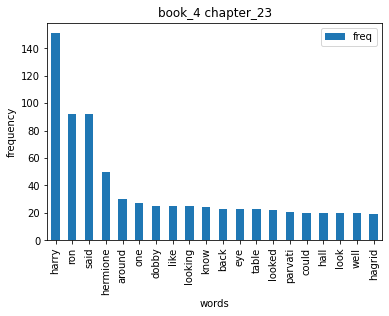

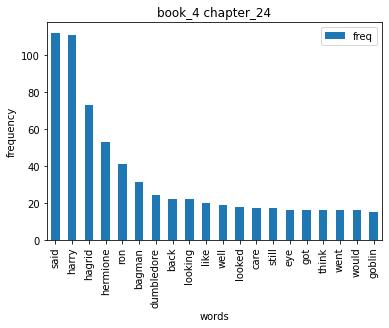

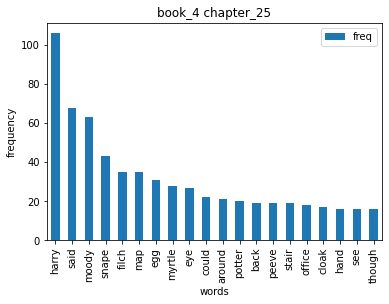

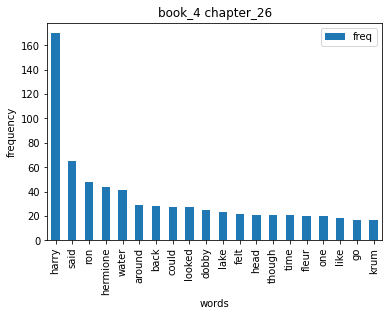

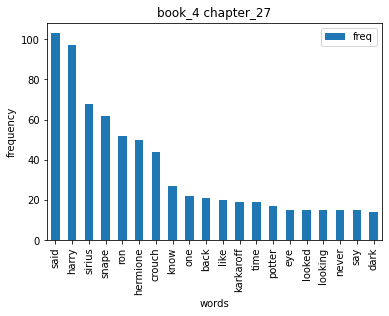

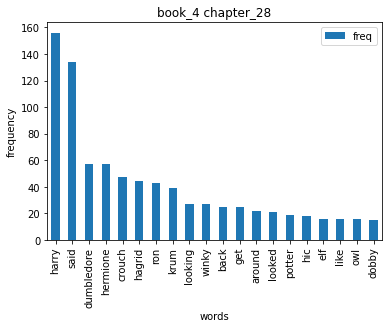

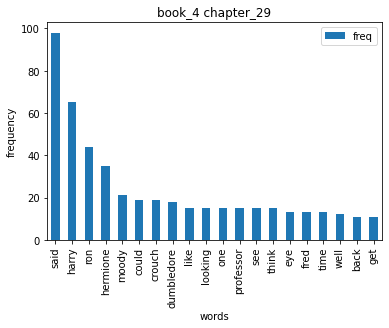

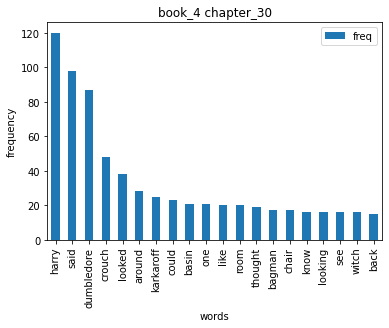

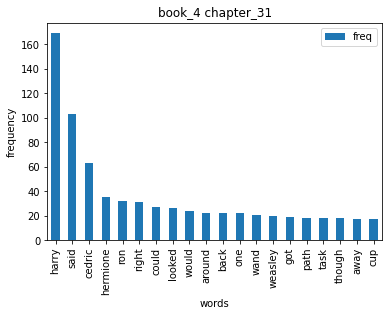

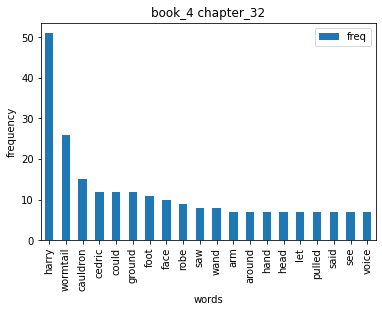

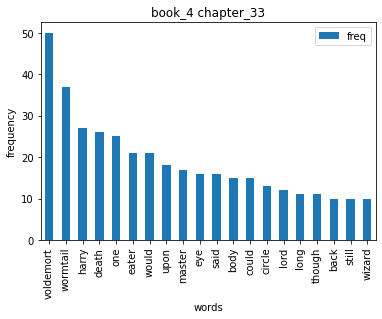

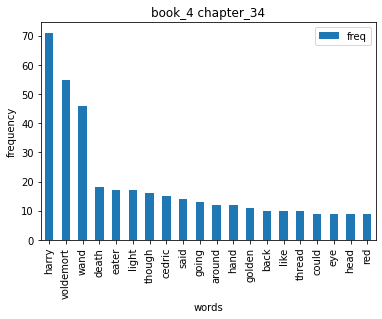

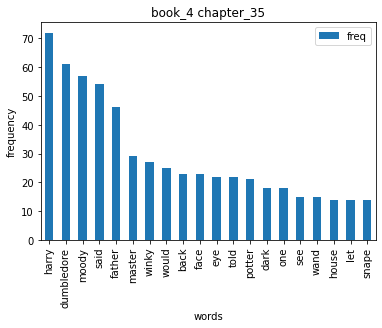

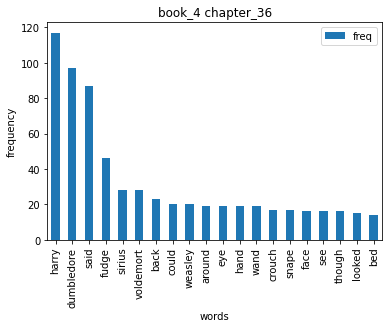

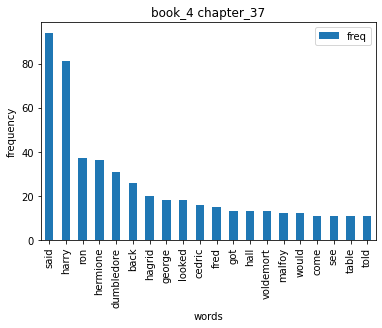

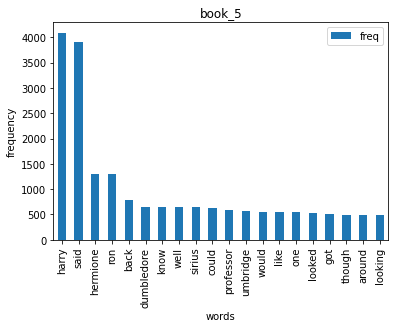

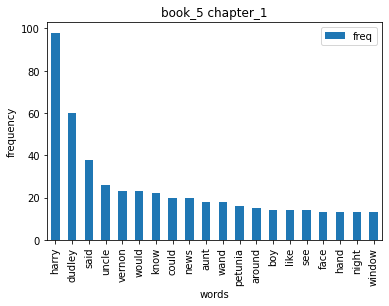

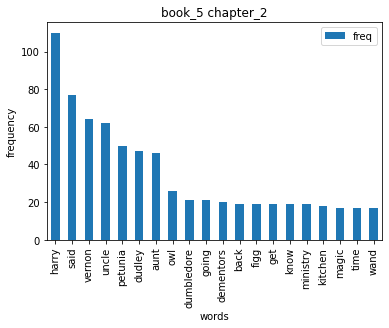

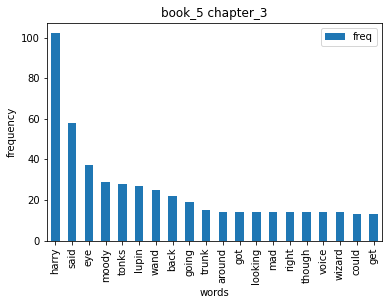

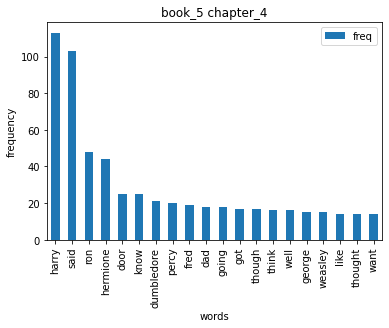

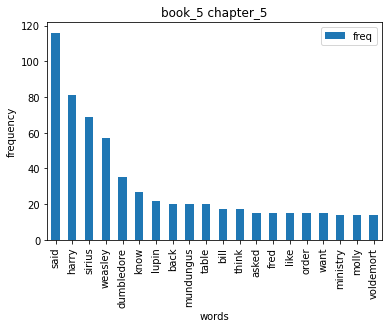

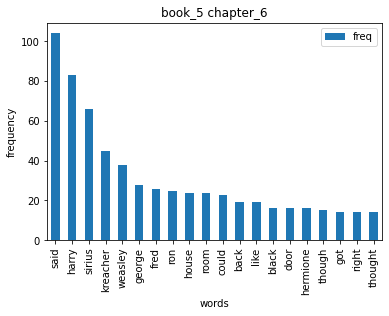

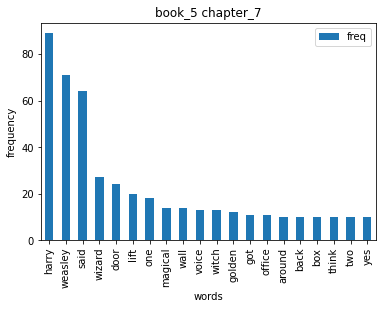

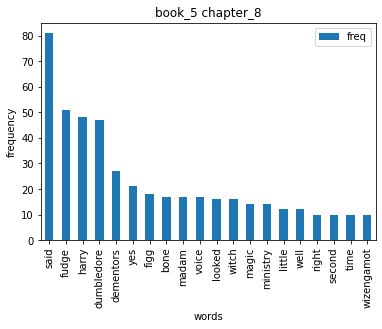

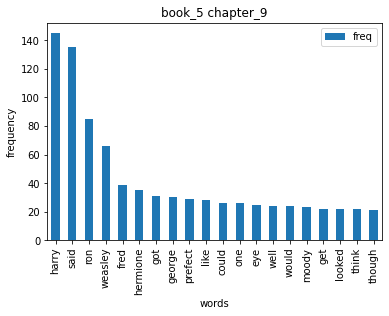

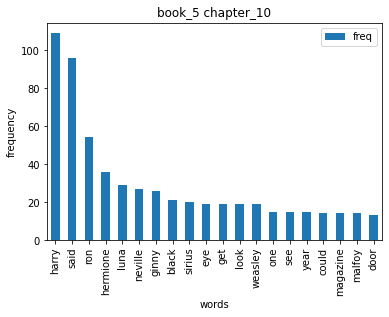

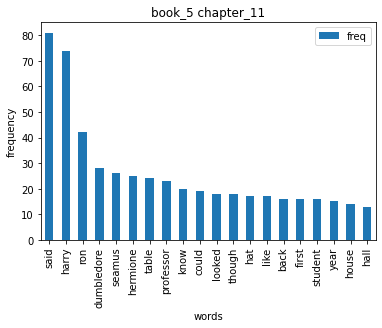

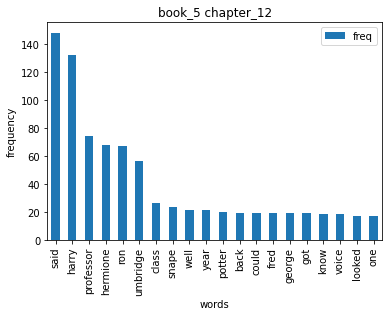

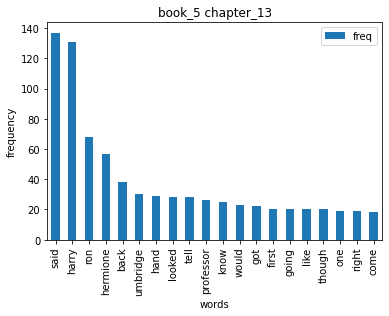

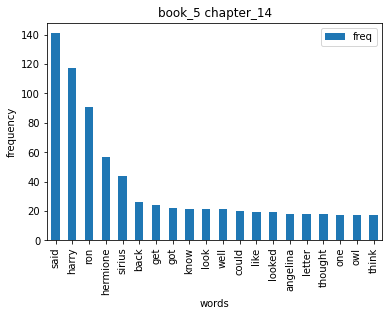

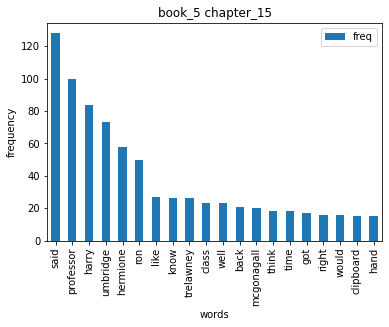

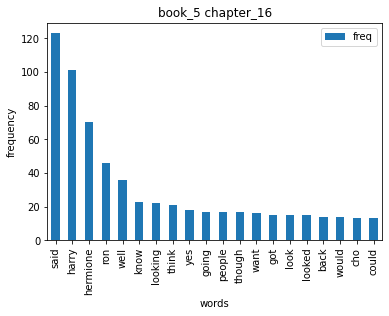

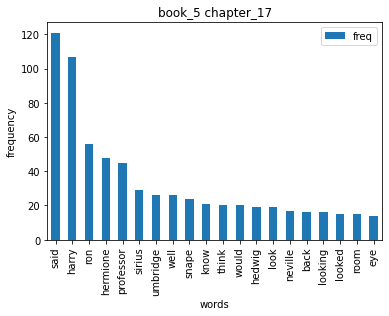

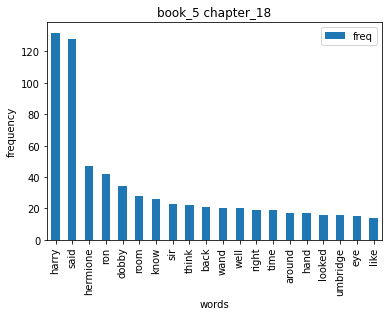

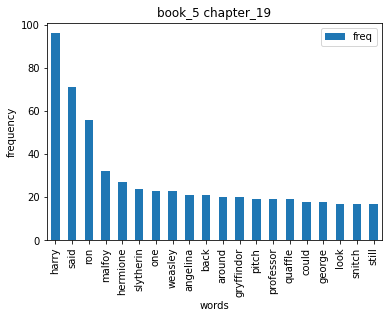

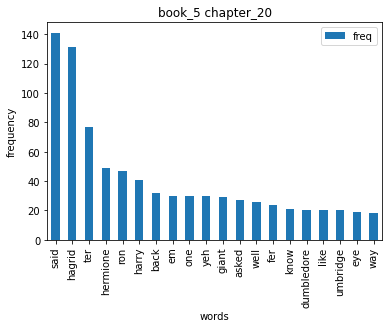

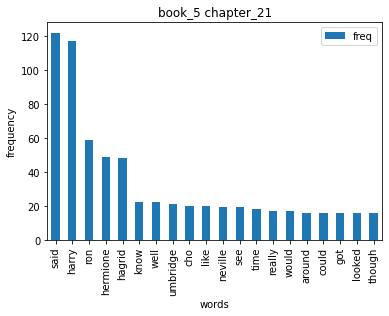

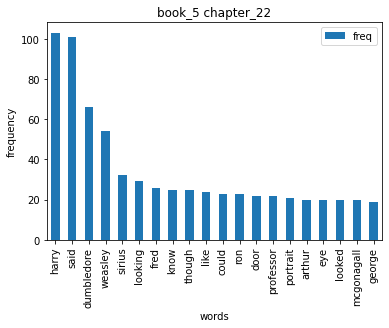

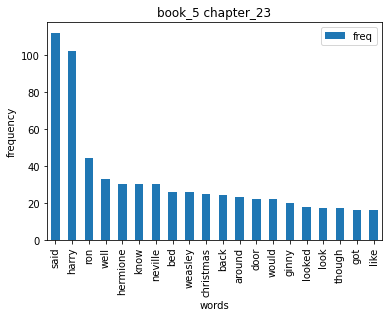

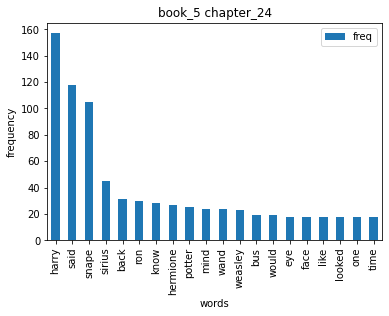

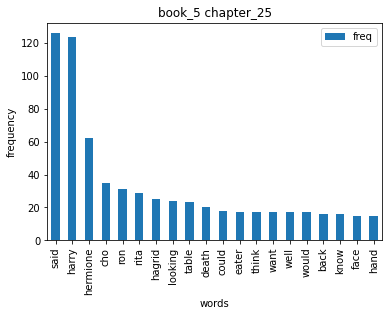

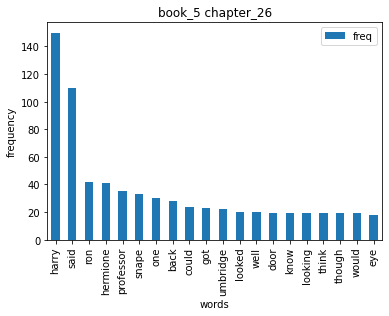

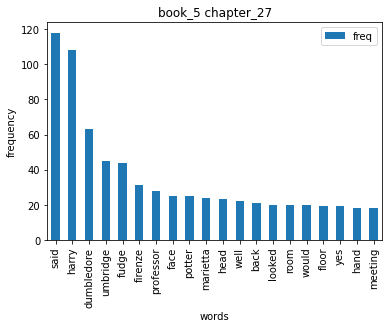

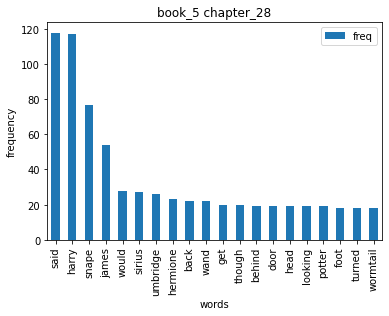

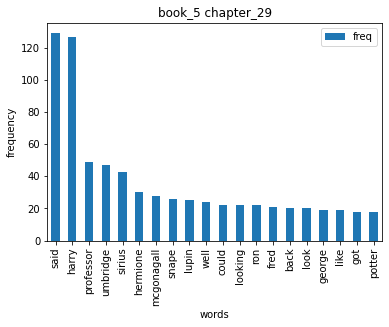

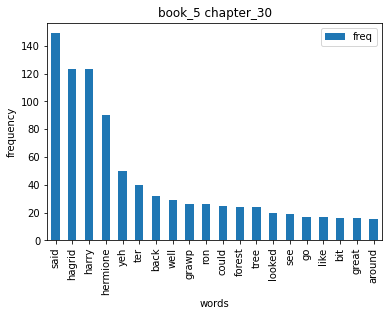

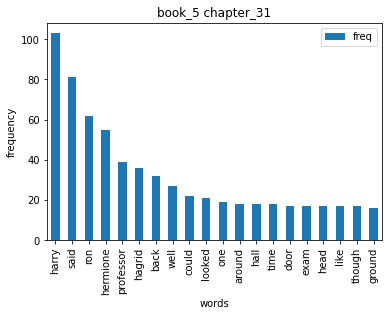

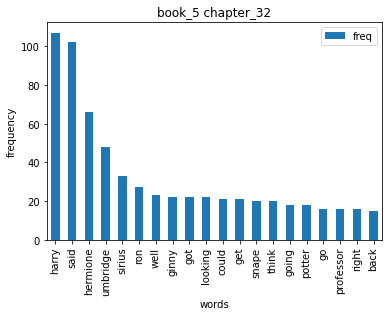

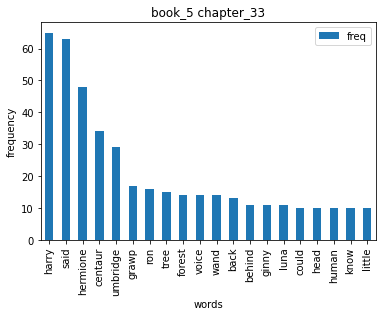

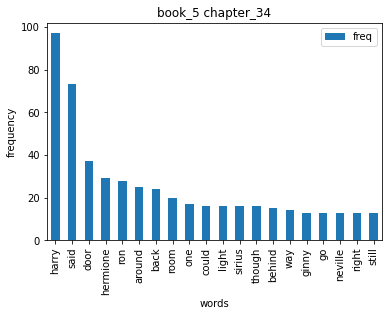

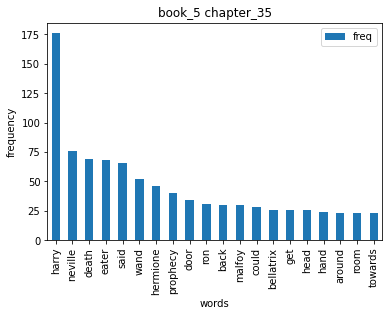

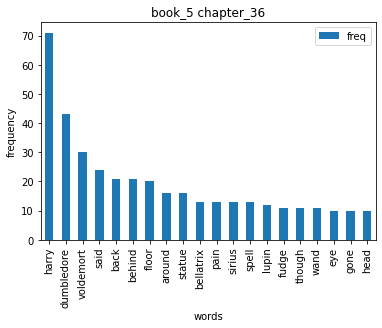

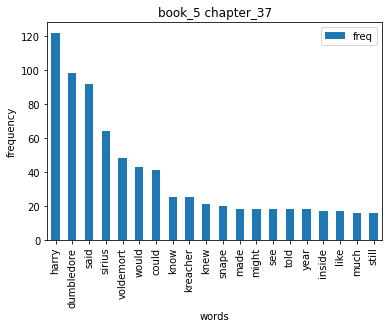

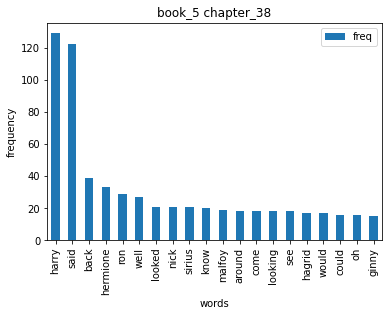

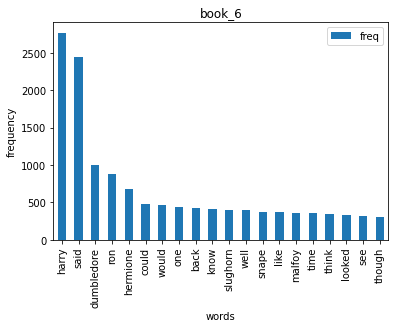

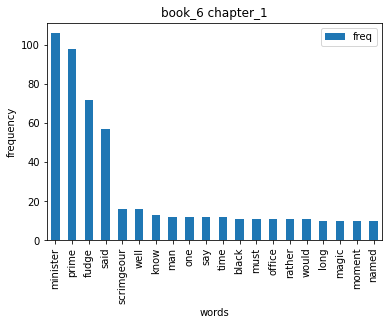

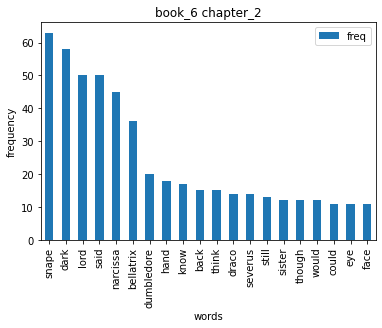

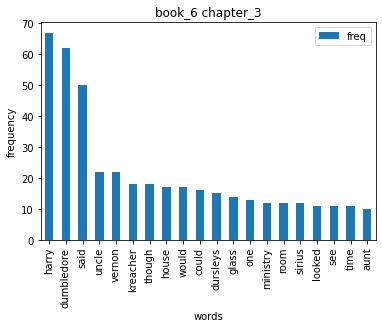

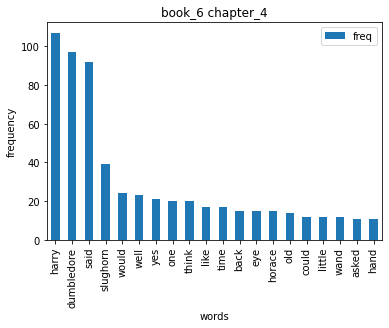

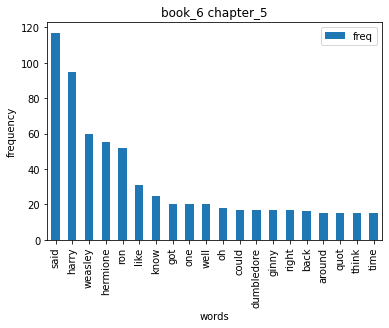

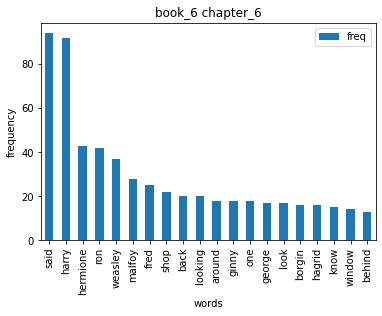

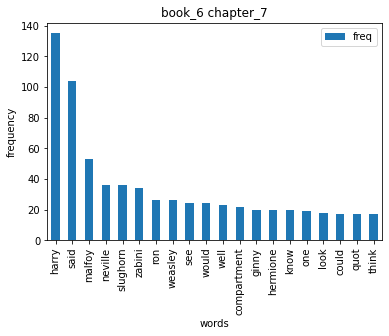

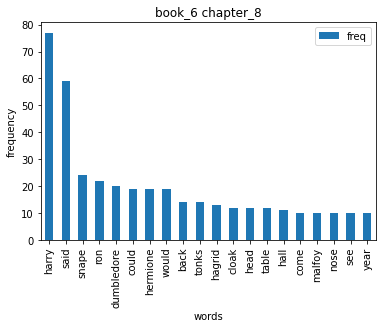

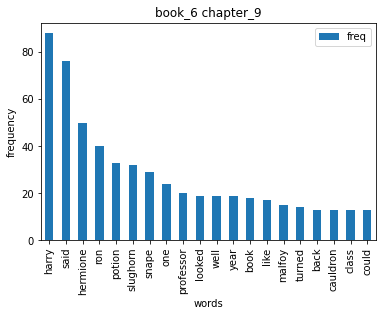

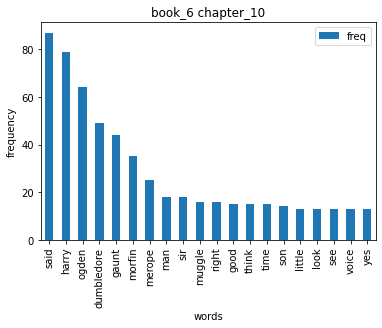

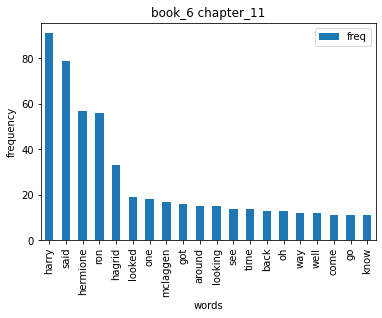

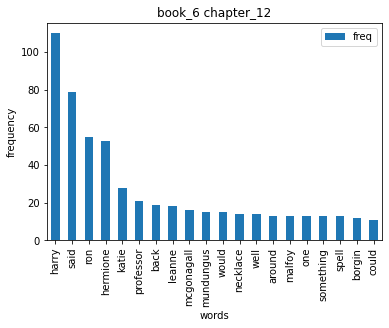

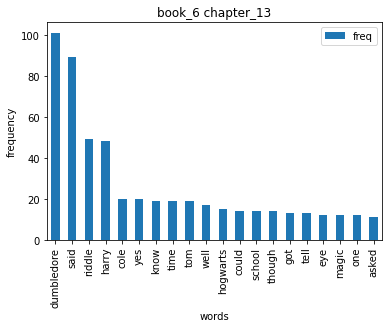

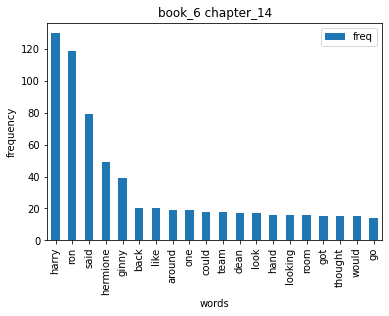

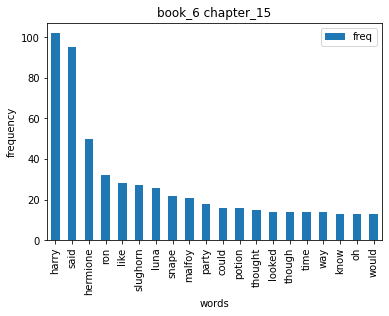

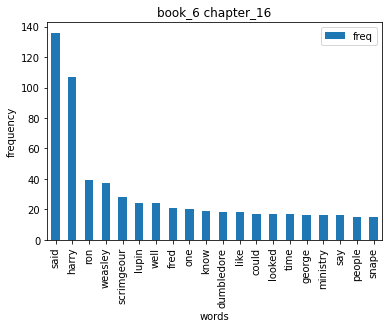

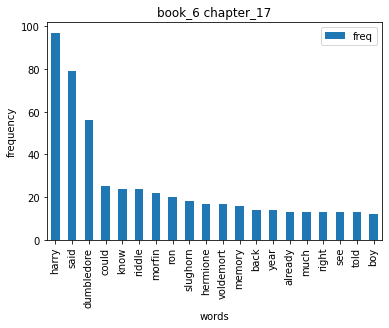

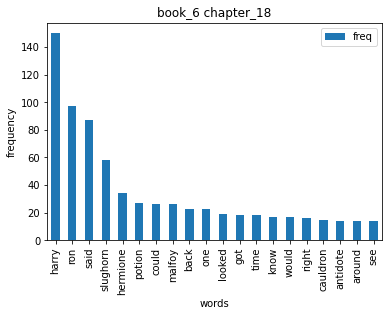

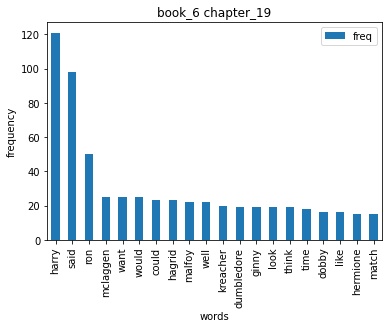

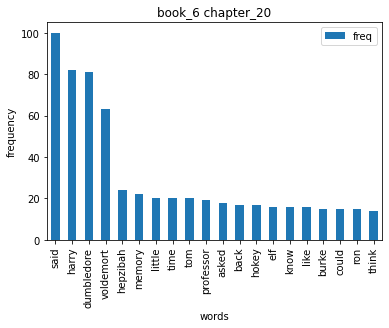

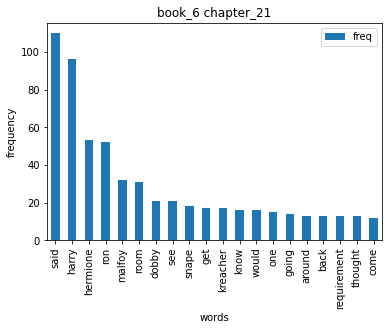

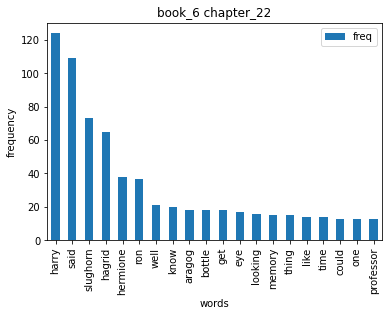

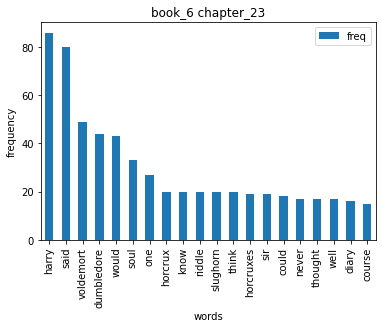

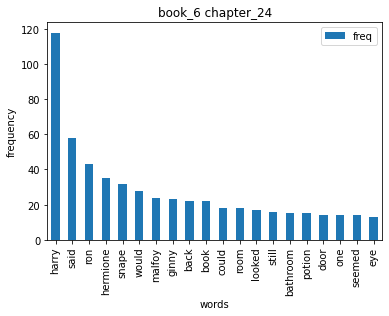

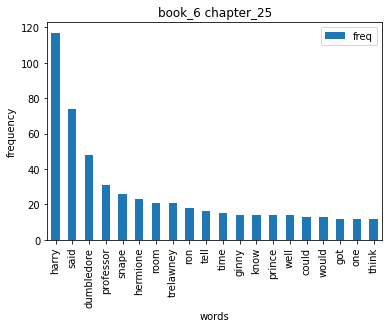

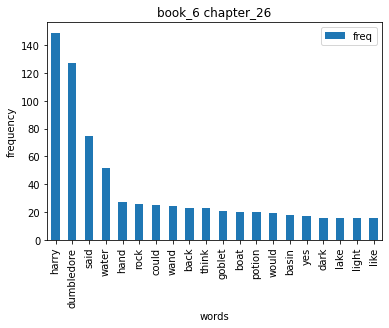

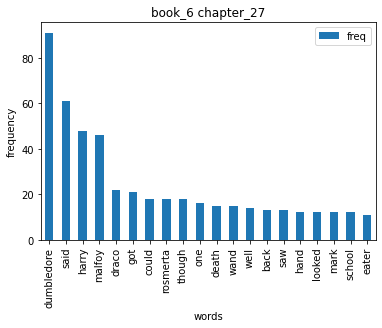

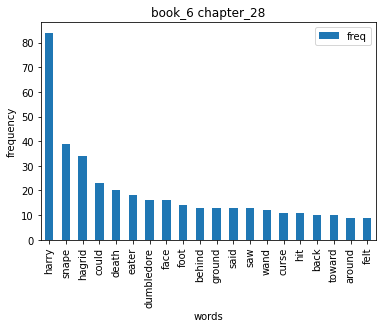

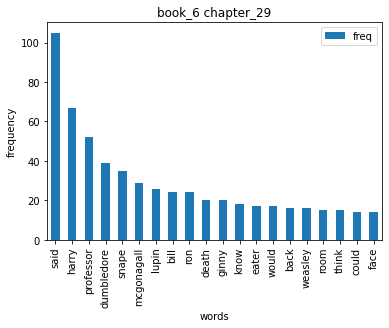

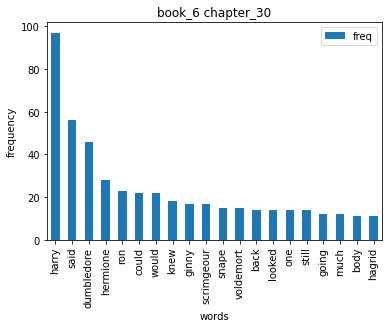

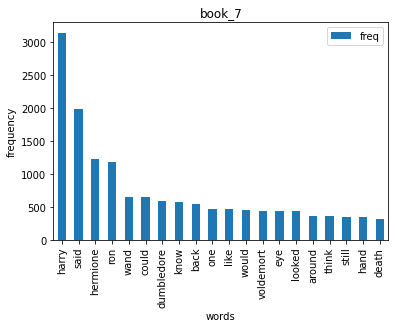

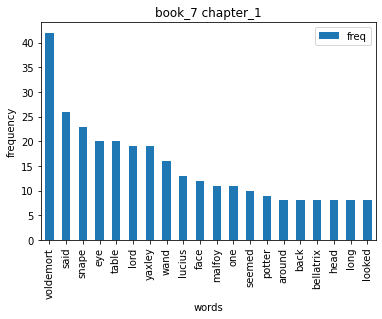

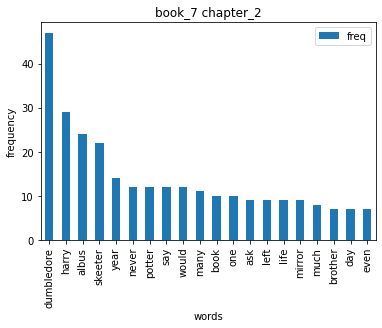

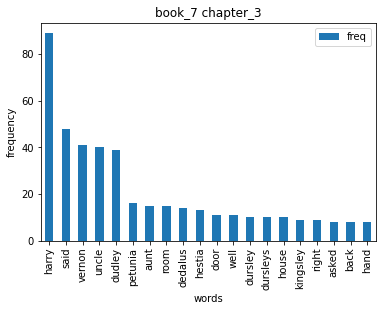

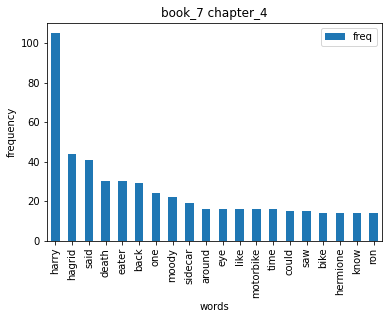

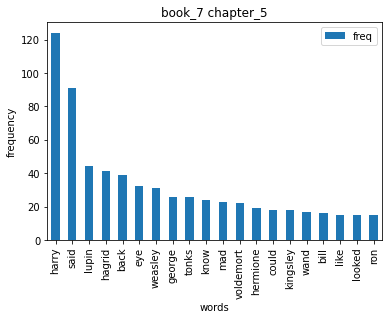

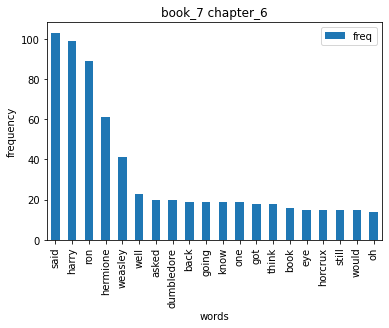

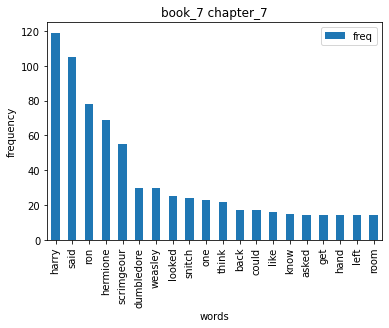

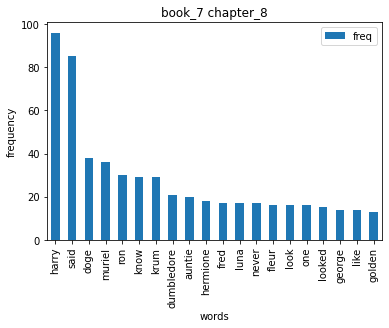

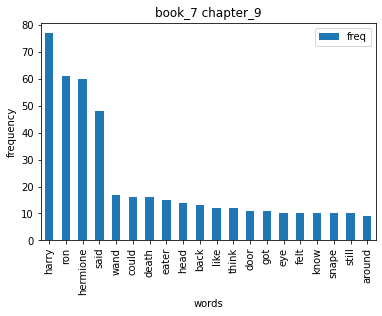

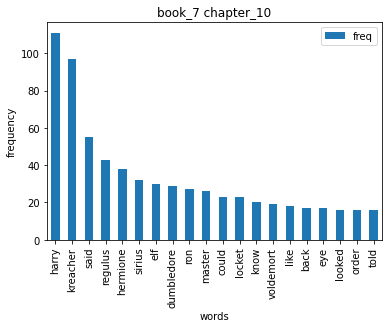

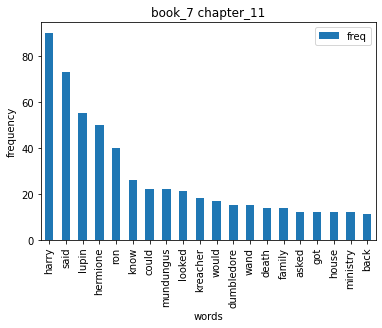

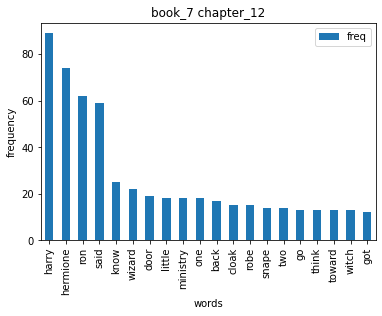

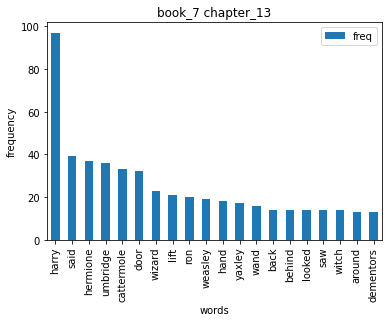

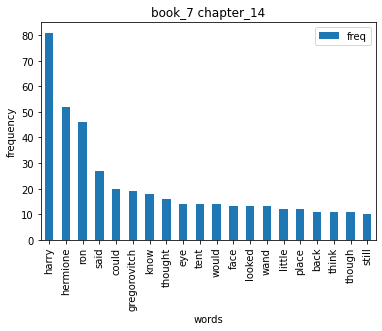

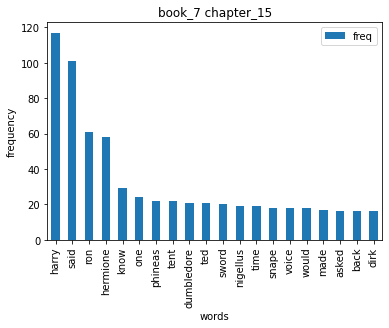

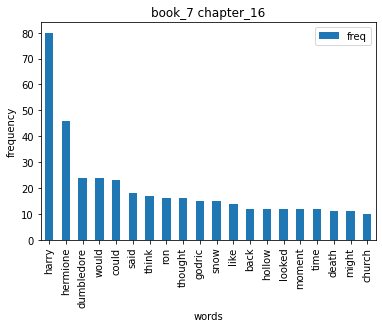

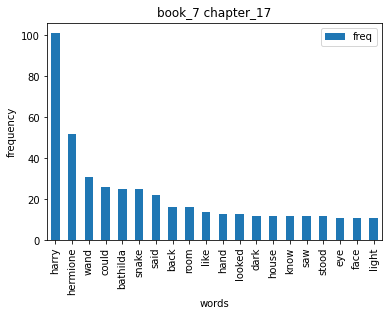

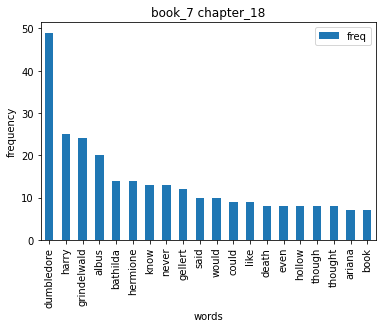

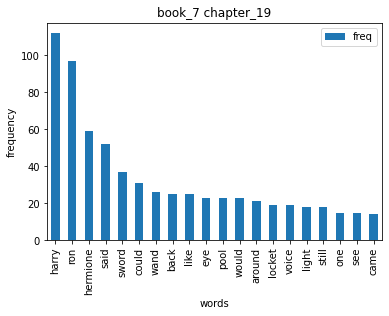

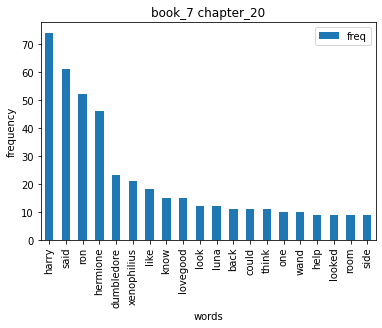

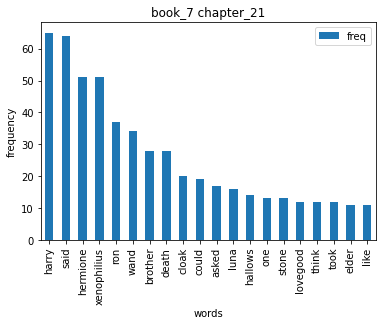

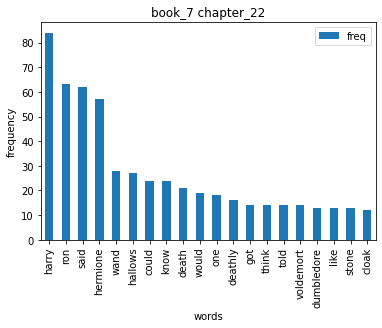

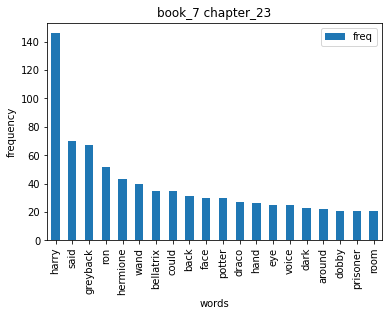

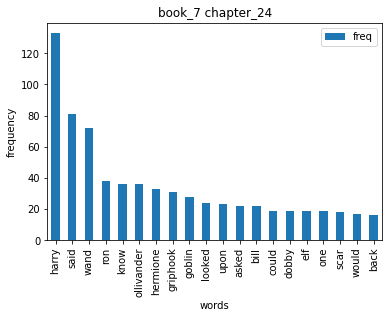

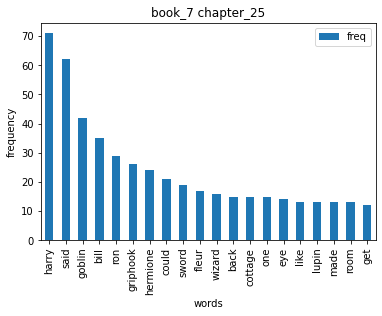

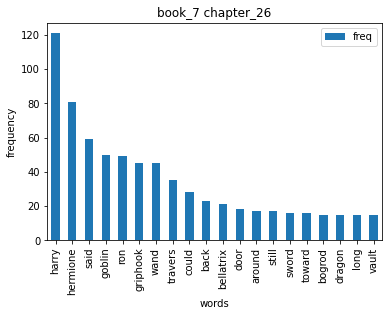

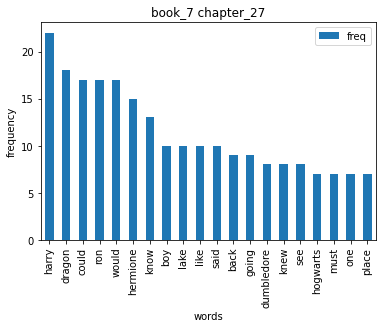

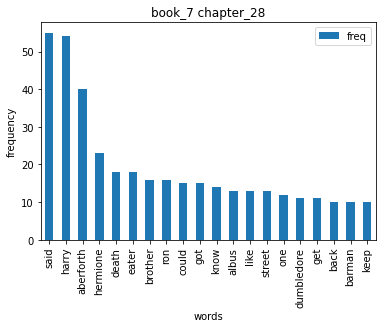

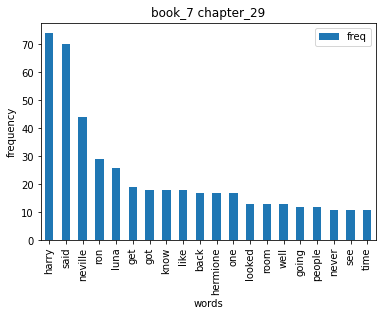

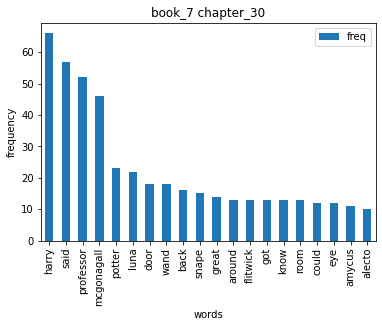

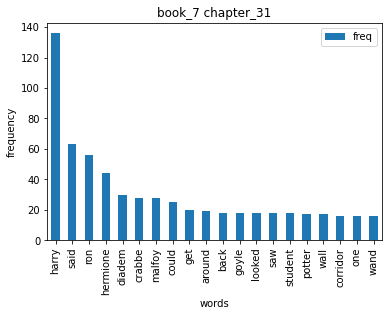

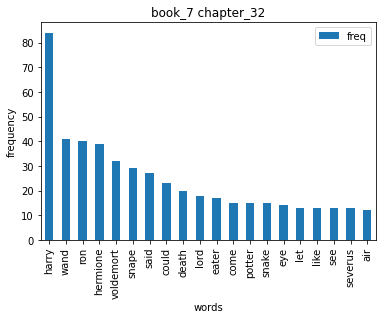

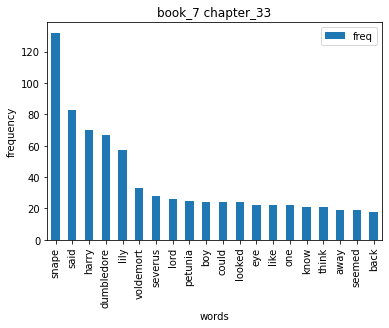

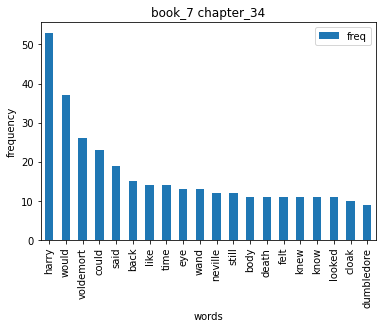

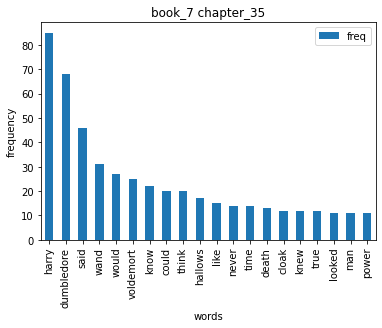

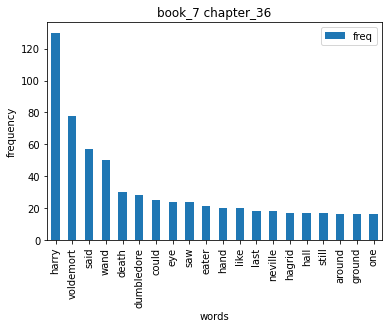

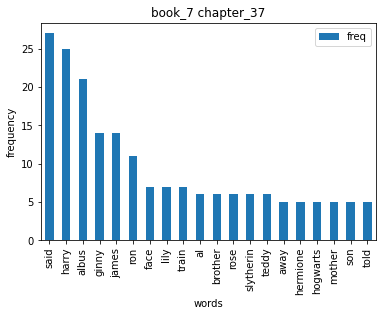

In [ ]:
print_stats(all_books,mode='chapter')

## N grams

In [ ]:
def count_grams(n=1,mode='book'):
  result = {}

  if mode =='book' or mode =='all':
    for book in books:
        result[book] = 0
        g = {}
        ngrams = nltk.ngrams(' '.join(all_books.loc[(book,),'preprocessed_text'].to_list()).split(),n)
        for gram in ngrams:
          if gram not in g:
            g[gram]=1
          else:
            g[gram]+=1
        g = sorted(g.items(),key=lambda x:x[1],reverse=True)
        result[book] = g
  if mode == 'chapter' or mode =='all':
    for (book,chapter) in books_chapters:
      name='book_{}_chapter_{}'.format(book,chapter)
      result[name] = 0
      g = {}
      ngrams = nltk.ngrams(all_books.loc[(book,chapter),'preprocessed_text'].split(),n)
      for gram in ngrams:
          if gram not in g:
            g[gram]=1
          else:
            g[gram]+=1
      g = sorted(g.values(),key=lambda x:x[1],reverse=True)
      result[book] = g
  return result

def visualize_grams(books,length=5):
  for book in books:
    print('book ',book,books[book][:length])

def find_gram(grams,query):
  result = {}
  for book in grams:
    result[book] = 0
    for gram in grams[book]:
      if ' '.join(gram[0]) == query or ' '.join(gram[0][::-1]) == query:
        result[book] +=gram[1]
  return pd.Series(result)


In [ ]:
# grams per book

_1grams = count_grams(n=1)
_2grams = count_grams(n=2)
_3grams = count_grams(n=3)
_4grams = count_grams(n=4)
_5grams = count_grams(n=5)
_6grams = count_grams(n=6)

In [ ]:
visualize_grams(_2grams)

book  1 [(('said', 'harry'), 143), (('said', 'ron'), 111), (('uncle', 'vernon'), 108), (('professor', 'mcgonagall'), 95), (('said', 'hagrid'), 91)]
book  2 [(('said', 'harry'), 229), (('said', 'ron'), 206), (('harry', 'ron'), 96), (('professor', 'mcgonagall'), 85), (('harry', 'potter'), 79)]
book  3 [(('said', 'harry'), 257), (('said', 'ron'), 175), (('said', 'hermione'), 122), (('professor', 'lupin'), 118), (('ron', 'hermione'), 106)]
book  4 [(('said', 'harry'), 437), (('said', 'ron'), 307), (('said', 'hermione'), 215), (('harry', 'said'), 164), (('harry', 'ron'), 151)]
book  5 [(('said', 'harry'), 702), (('said', 'hermione'), 417), (('said', 'ron'), 345), (('harry', 'said'), 191), (('professor', 'umbridge'), 186)]
book  6 [(('said', 'harry'), 537), (('said', 'dumbledore'), 286), (('said', 'ron'), 195), (('said', 'hermione'), 182), (('harry', 'said'), 113)]
book  7 [(('said', 'harry'), 407), (('said', 'ron'), 239), (('said', 'hermione'), 225), (('death', 'eater'), 203), (('ron', 'her

In [ ]:
visualize_grams(_3grams)

book  1 [(('said', 'professor', 'mcgonagall'), 16), (('nimbus', 'two', 'thousand'), 15), (('said', 'uncle', 'vernon'), 13), (('harry', 'could', 'see'), 10), (('harry', 'ron', 'hermione'), 10)]
book  2 [(('nearly', 'headless', 'nick'), 33), (('said', 'professor', 'mcgonagall'), 21), (('harry', 'ron', 'hermione'), 19), (('harry', 'could', 'see'), 15), (('moaning', 'myrtle', 'bathroom'), 12)]
book  3 [(('harry', 'ron', 'hermione'), 44), (('said', 'professor', 'mcgonagall'), 27), (('said', 'professor', 'lupin'), 23), (('defense', 'dark', 'art'), 22), (('yes', 'said', 'harry'), 12)]
book  4 [(('harry', 'ron', 'hermione'), 74), (('quidditch', 'world', 'cup'), 33), (('harry', 'could', 'see'), 28), (('yeah', 'said', 'harry'), 27), (('harry', 'looked', 'around'), 24)]
book  5 [(('yeah', 'said', 'harry'), 45), (('defence', 'dark', 'art'), 45), (('harry', 'ron', 'hermione'), 42), (('said', 'professor', 'mcgonagall'), 42), (('said', 'professor', 'umbridge'), 36)]
book  6 [(('harry', 'ron', 'hermio

In [ ]:
visualize_grams(_4grams)

book  1 [(('platform', 'nine', 'three', 'quarter'), 7), (('vault', 'seven', 'hundred', 'thirteen'), 6), (('bott', 'every', 'flavor', 'bean'), 4), (('uncle', 'vernon', 'aunt', 'petunia'), 3), (('hogwarts', 'school', 'witchcraft', 'wizardry'), 3)]
book  2 [(('said', 'nearly', 'headless', 'nick'), 7), (('hogwarts', 'school', 'witchcraft', 'wizardry'), 5), (('justin', 'nearly', 'headless', 'nick'), 5), (('defense', 'dark', 'art', 'teacher'), 4), (('harry', 'potter', 'said', 'riddle'), 4)]
book  3 [(('uncle', 'vernon', 'aunt', 'petunia'), 6), (('defense', 'dark', 'art', 'teacher'), 6), (('committee', 'disposal', 'dangerous', 'creature'), 6), (('moony', 'wormtail', 'padfoot', 'prong'), 5), (('expecto', 'patronum', 'expecto', 'patronum'), 4)]
book  4 [(('said', 'nearly', 'headless', 'nick'), 7), (('put', 'name', 'goblet', 'fire'), 7), (('uncle', 'vernon', 'aunt', 'petunia'), 6), (('department', 'international', 'magical', 'cooperation'), 6), (('department', 'regulation', 'control', 'magical')

In [ ]:
visualize_grams(_5grams)

book  1 [(('one', 'thousand', 'magical', 'herb', 'fungi'), 3), (('often', 'said', 'dudley', 'looked', 'like'), 2), (('read', 'hogwarts', 'school', 'witchcraft', 'wizardry'), 2), (('say', 'died', 'opinion', 'dunno', 'enough'), 2), (('died', 'opinion', 'dunno', 'enough', 'human'), 2)]
book  2 [(('witch', 'weekly', 'charming', 'smile', 'award'), 3), (('riddle', 'got', 'award', 'special', 'service'), 3), (('making', 'noise', 'pretending', 'said', 'harry'), 2), (('room', 'making', 'noise', 'pretending', 'said'), 2), (('allowed', 'use', 'magic', 'outside', 'school'), 2)]
book  3 [(('holiday', 'uncle', 'vernon', 'aunt', 'petunia'), 2), (('uncle', 'vernon', 'new', 'company', 'car'), 2), (('harry', 'went', 'breakfast', 'next', 'morning'), 2), (('st', 'brutus', 'secure', 'center', 'criminal'), 2), (('brutus', 'secure', 'center', 'criminal', 'boy'), 2)]
book  4 [(('department', 'regulation', 'control', 'magical', 'creature'), 6), (('st', 'mungo', 'hospital', 'magical', 'malady'), 4), (('mungo', '

In [ ]:
visualize_grams(_6grams)

book  1 [(('say', 'died', 'opinion', 'dunno', 'enough', 'human'), 2), (('died', 'opinion', 'dunno', 'enough', 'human', 'left'), 2), (('opinion', 'dunno', 'enough', 'human', 'left', 'die'), 2), (('dumbledore', 'particularly', 'famous', 'defeat', 'dark', 'wizard'), 2), (('particularly', 'famous', 'defeat', 'dark', 'wizard', 'grindelwald'), 2)]
book  2 [(('gilderoy', 'lockhart', 'order', 'merlin', 'third', 'class'), 2), (('lockhart', 'order', 'merlin', 'third', 'class', 'member'), 2), (('order', 'merlin', 'third', 'class', 'member', 'dark'), 2), (('merlin', 'third', 'class', 'member', 'dark', 'force'), 2), (('third', 'class', 'member', 'dark', 'force', 'defense'), 2)]
book  3 [(('st', 'brutus', 'secure', 'center', 'criminal', 'boy'), 2), (('outside', 'florean', 'fortescue', 'ice', 'cream', 'parlor'), 2), (('around', 'easter', 'one', 'number', 'leave', 'u'), 2), (('easter', 'one', 'number', 'leave', 'u', 'forever'), 2), (('said', 'cold', 'drawling', 'voice', 'draco', 'malfoy'), 2)]
book  4

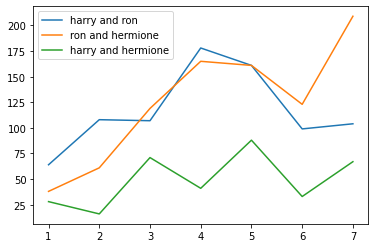

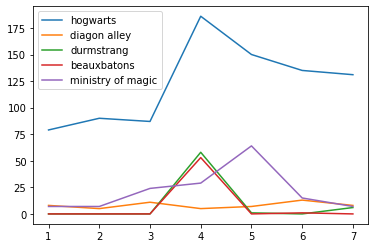

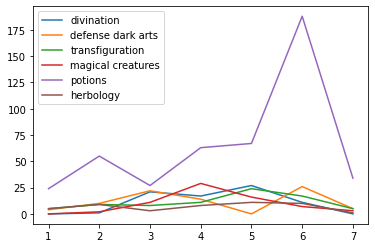

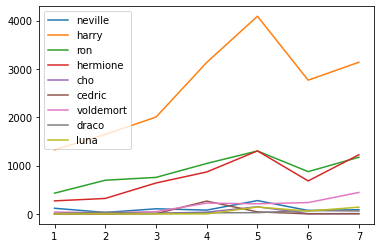

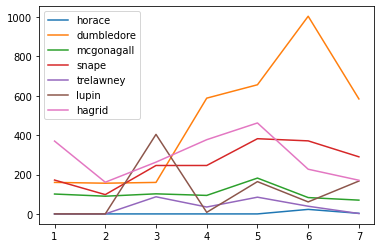

In [ ]:
# relation among  main characters
query1 = find_gram(_2grams,'harry ron')
query2 = find_gram(_2grams,'ron hermione')
query3 = find_gram(_2grams,'harry hermione')

# places
query4 = find_gram(_1grams,'hogwarts')
query5 = find_gram(_2grams,'diagon alley')
query6 = find_gram(_1grams,'durmstrang')
query7 = find_gram(_1grams,'beauxbatons')
query8 =find_gram(_2grams,'ministry magic')

# lessons
query9 = find_gram(_1grams,'divination')
query10 = find_gram(_3grams,'defense dark art')
query11 = find_gram(_1grams,'transfiguration')
query12 = find_gram(_2grams,'magical creature')
query13 = find_gram(_1grams,'potion')
query14 = find_gram(_1grams,'herbology')

# characters
query15 = find_gram(_1grams,'neville')
query16 = find_gram(_1grams,'harry')
query17 = find_gram(_1grams,'ron')
query18 = find_gram(_1grams,'hermione')
query19 = find_gram(_1grams,'cho')
query20 = find_gram(_1grams,'cedric')
query21 = find_gram(_1grams,'voldemort')
query22 = find_gram(_1grams,'draco')
query23 = find_gram(_1grams,'luna')

# professors

query24 = find_gram(_1grams,'horace')
query25 = find_gram(_1grams,'dumbledore')
query26 = find_gram(_1grams,'mcgonagall')
query27 = find_gram(_1grams,'snape')
query28 = find_gram(_1grams,'trelawney')
query29 = find_gram(_1grams,'lupin')
query30 = find_gram(_1grams,'hagrid')

fig, ax = plt.subplots()
df = pd.DataFrame({'harry and ron':query1,
                   'ron and hermione':query2,
                   'harry and hermione':query3
                   })
df.plot( ax=ax)

fig2, ax2 = plt.subplots()
df2 = pd.DataFrame({'hogwarts':query4,
                    'diagon alley':query5,
                    'durmstrang':query6,
                    'beauxbatons':query7,
                    'ministry of magic':query8
                    })
df2.plot( ax=ax2)

fig3, ax3 = plt.subplots()
df3 = pd.DataFrame({'divination':query9,
                    'defense dark arts':query10,
                    'transfiguration':query11,
                    'magical creatures':query12,
                    'potions':query13,
                    'herbology':query14})
df3.plot( ax=ax3)

fig4, ax4 = plt.subplots()
df4 = pd.DataFrame({'neville':query15,
                    'harry':query16,
                    'ron':query17,
                    'hermione':query18,
                    'cho':query19,
                    'cedric':query20,
                    'voldemort':query21,
                    'draco':query22,
                    'luna':query23})
df4.plot( ax=ax4)

fig5, ax5 = plt.subplots()
df5 = pd.DataFrame({'horace':query24,
                    'dumbledore':query25,
                    'mcgonagall':query26,
                    'snape':query27,
                    'trelawney':query28,
                    'lupin':query29,
                    'hagrid':query30
                    })
df5.plot( ax=ax5)

In [ ]:
class NgramModel(object):

  def __init__(self, n):
    self.n = n

    # dictionary that keeps list of candidate words given context
    self.context = {}

    # keeps track of how many times ngram has appeared in the text before
    self.ngram_counter = {}

  def tokenize(self,text):
    """
    :param text: Takes input sentence
    :return: tokenized sentence
    """
    for punct in punctuation:
        text = text.replace(punct, ' '+punct+' ')
    t = text.split()
    return t

  def get_ngrams(self,n, tokens):
    """
    :param n: n-gram size
    :param tokens: tokenized sentence
    :return: list of ngrams
    ngrams of tuple form: ((previous wordS!), target word)
    """
    # tokens.append('<END>')
    tokens = (n-1)*['<START>']+tokens
    l = [(tuple([tokens[i-p-1] for p in reversed(range(n-1))]), tokens[i]) for i in range(n-1, len(tokens))]
    return l

  def update(self, sentence):
      """
      Updates Language Model
      :param sentence: input text
      """
      n = self.n
      ngrams = self.get_ngrams(n, self.tokenize(sentence))
      for ngram in ngrams:
          if ngram in self.ngram_counter:
              self.ngram_counter[ngram] += 1.0
          else:
              self.ngram_counter[ngram] = 1.0

          prev_words, target_word = ngram
          if prev_words in self.context:
              self.context[prev_words].append(target_word)
          else:
              self.context[prev_words] = [target_word]

  def prob(self, context, token):
      """
      Calculates probability of a candidate token to be generated given a context
      :return: conditional probability
      """
      try:
          count_of_token = self.ngram_counter[(context, token)]
          count_of_context = float(len(self.context[context]))
          result = count_of_token / count_of_context

      except KeyError:
          result = 0.0
      return result

  def random_token(self, context):
      """
      Given a context we "semi-randomly" select the next word to append in a sequence
      :param context:
      :return:
      """
      r = random.random()
      map_to_probs = {}
      token_of_interest = self.context[context]
      for token in token_of_interest:
          map_to_probs[token] = self.prob(context, token)

      summ = 0
      for token in sorted(map_to_probs):
          summ += map_to_probs[token]
          if summ > r:
              return token

  def generate_text(self, token_count):
      """
      :param token_count: number of words to be produced
      :return: generated text
      """
      n = self.n
      context_queue = (n - 1) * ['<START>']
      result = []
      for _ in range(token_count):
          obj = self.random_token(tuple(context_queue))
          result.append(obj)
          if n > 1:
              context_queue.pop(0)
              if obj == '.':
                  context_queue = (n - 1) * ['<START>']
              else:
                  context_queue.append(obj)
      return ' '.join(result)


def create_ngram_model(n, text):
    m = NgramModel(n)
    text = text.split('.')
    for sentence in text:
      # add back the fullstop
      sentence += '.'
      m.update(sentence)
    return m

start = time.time()
text = all_books['Text'].apply(lambda x: preprocess_pipeline(x,remove_dot=False))
text = ' '.join(text)
m = create_ngram_model(6, text)

print(f'Language Model creating time: {time.time() - start}')
start = time.time()
random.seed(7)
print(f'{"="*50}\nGenerated text:')
m.generate_text(500)

Language Model creating time: 62.09668588638306
Generated text:


'door closed last student sat tree stump beside wastepaper basket firenze gestured around room . angelina nearly tear end . wonder bulgarian got dangling tent said hermione . . look pale . know . . . one landing umbridge office harry thought safe become visible . huge photograph face filled front page . ron fang thudded next . said lavender suddenly making everyone start . harry sure whether imagination rather thought saw small cloud bird air tree top distance almost though tree pulled root . bet expected refuse anyway . know thing said harry looking smooth water . well better expelled able defend sitting safely school without clue said sirius . patronuses people managed conjure faded away silver mist leaving room looking much darker . . . . echoing bang slammed cellar door died away terrible drawn scream directly . far aware know day riddle died kedavra curse usually leave sign damage . weasley left kitchen . . idea worried said . brought carefully inside . instant thought occurred ow

## Tokenization

Tokenization made by the `word_tokenize` tokenizer of the NLTK package

In [ ]:
all_books['tokenized'] = all_books['preprocessed_text'].apply(lambda x: x.split())

In [ ]:
all_books.head()

Text  ...                                          tokenized
Book Chapter                                                     ...                                                   
1    1        THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...  ...  [boy, lived, dursley, number, four, privet, dr...
     2        THE VANISHING GLASS  Nearly ten years had pass...  ...  [vanishing, glass, nearly, ten, year, passed, ...
     3        THE LETTERS FROM NO ONE  The escape of the Bra...  ...  [letter, one, escape, boa, constrictor, earned...
     4        THE KEEPER OF THE KEYS  BOOM. They knocked aga...  ...  [keeper, key, knocked, dudley, jerked, awake, ...
     5        DIAGON ALLEY  Harry woke early the next mornin...  ...  [diagon, alley, harry, woke, early, next, morn...

[5 rows x 5 columns]

## Vocabulary

In [ ]:
def build_vocabulary(df):
  """
  Return idx_to_word, word_to_idx, word_list
  OrderedDict preserves the order in which the keys are inserted. 
  A regular dict doesn’t track the insertion order, and iterating it gives the values in an arbitrary order. 
  By contrast, the order the items are inserted is remembered by OrderedDict.
  """
  idx_to_word=OrderedDict()
  word_to_idx=OrderedDict()
  word_list=[]
  i=0
  for index,row in df.iterrows():
    _word_list = row['tokenized']
    for w in _word_list:
      if w not in word_list:
        word_list.append(w)
        word_to_idx[w] = i
        idx_to_word[i] = w
        i+= 1
  return idx_to_word,word_to_idx,word_list

def word_frequency(df,word_to_idx):
  """
  Helper function to create the term/document matrix
  """
  data = []
  for index,row in df.iterrows():
    _data = [0]*len(word_to_idx)
    book, chapter = index
    tokens = df.loc[(book, chapter),:]['tokenized']
    for t in tokens:
      _data[word_to_idx[t]] += 1
    data.append(_data)
  return data

In [ ]:
idx_to_word,word_to_idx,word_list = build_vocabulary(all_books)

In [ ]:
print(f'vocabulary length : {len(word_list)}')

vocabulary length : 7174


## Term-doc matrix

In [ ]:
# term doc matrix with frequency

data = word_frequency(all_books, word_to_idx)
term_doc_matrix = pd.DataFrame(data = data, index = all_books.index, columns = word_list)
term_doc_matrix.T

Book       1                               ...  7                             
Chapter   1  2  3  4   5   6  7  8  9  10  ... 28 29 30  31 32  33 34 35 36 37
boy       10  7  2  5  15  34  5  1  7  1  ...  5  0  4   2  6  24  4  6  9  1
lived      2  3  0  2   0   0  0  1  0  0  ...  0  0  0   2  1   1  2  0  2  0
dursley   47  3  0  6   0   0  0  0  0  0  ...  0  0  0   0  0   0  0  0  0  0
number     8  1  1  0   1   4  0  0  1  0  ...  0  0  0   2  0   0  1  0  1  1
four       6  2  5  0   2   4  6  0  1  2  ...  0  0  0   2  2   1  2  0  1  2
...       .. .. .. ..  ..  .. .. .. .. ..  ... .. .. ..  .. ..  .. .. .. .. ..
listener   0  0  0  0   0   0  0  0  0  0  ...  0  0  0   0  0   0  0  0  0  0
scabior    0  0  0  0   0   0  0  0  0  0  ...  0  0  0   0  0   0  0  0  0  0
diadem     0  0  0  0   0   0  0  0  0  0  ...  0  7  4  30  1   0  0  0  0  0
bogrod     0  0  0  0   0   0  0  0  0  0  ...  0  0  0   0  0   0  0  0  0  0
tuney      0  0  0  0   0   0  0  0  0  0  ...  0  0  0   0  0   6  0  0  0  0

[7174 rows x 200 columns]

## TF-IDF

TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general

In [ ]:
def tf_idf(matrix):
  """
  matrix : shape (terms,documents)
  """
  N = matrix.shape[1]
  tfidf = np.zeros((matrix.shape[0],N))
  for i,el in enumerate(matrix):
    v_doc = list(filter(lambda x:x!=0,el))
    for j,freq in enumerate(el):
      if freq > 0:
        tfidf[i][j] = (1 + np.log10(freq))*np.log10(N /len(v_doc))
  df = pd.DataFrame(data = tfidf, index = word_list, columns = all_books.index)
  return df

def select_features(df,threshold):
  """
  sort words according to their tf-idf value
  and build a new vocab based on these new features
  """
  vocab = set()
  result = OrderedDict()
  books = df.columns.levels[0]
  for book in books:
    chapters = df[book].columns
    ch_features = {}
    for chapter in chapters:
      # select for each chapters words that have a tf-idf value greater than a fixed threshold
      selected_features = df.loc[:,(book,chapter)][df.loc[:,(book,chapter)] > threshold].sort_values(ascending=False).index 
      ch_features[chapter] = selected_features
      vocab.update(selected_features)
    result[book] = ch_features
  return vocab,result

def print_feature(features,show=10):
  """
  print the most relevant features per document
  """
  for book,value in features.items():
    for key,f in value.items():
      print(f'Book_{book} Chapter_{key} : ')
      print(f[:show])
  
def jaccard(query,features,deep=False):
  """
  compute the jaccard distance between a query and a document
  """
  res = OrderedDict()
  w_query = query.split()
  if deep:
    for (book,chapter) in features.index:
      name = 'book_{} chapter_{}'.format(book,chapter)
      f = features.loc[(book,chapter),'tokenized']
      res[name] = 1 - _jaccard_coefficient(w_query,f)

  else:
    for book,value in features.items():
      for chapter,f in value.items():
        name = 'book_{} chapter_{}'.format(book,chapter)
        res[name] = 1 - _jaccard_coefficient(w_query,f)
  return print(sorted(res.items(),key=lambda x:x[1]))

def _jaccard_coefficient(list1, list2):
  """
  compute jaccard coefficient
  """
  intersection = len(list(set(list1).intersection(list2)))
  union = (len(list1) + len(list2)) - intersection
  return intersection / union

def _cosine(s1,s2):
  """
  compute cosine similarity
  """
  norm1 = np.linalg.norm(s1,axis=0) if np.linalg.norm(s1,axis=0) > 0 else 1
  norm2 = np.linalg.norm(s2,axis=0) if np.linalg.norm(s2,axis=0) > 0 else 1
  return ((sum(s1*s2)) / (norm1*norm2))

def cosine_similarity(df,word,threshold=0.5,norm=False,reverse=True,dim=False,doc=False):
  """
  output cosine + norm between words
  """
  p = {}
  if dim:
    a = df.loc[word,:][dim[0]:dim[1]+1]
  else:
    a = df.loc[word,:]
  for word,row in df.iterrows():
    if dim:
      b = df.loc[word,:][dim[0]:dim[1]+1]
    else:
      b = df.loc[word,:]
    cos = _cosine(a,b)
    if cos > threshold:
      norm = np.linalg.norm(b,ord=2,axis=0)
      p[word] = (cos,norm)
  if norm:
    result = sorted(p.items(),key=lambda x:x[1][0],reverse=reverse)
  else:
    result = sorted(p.items(),key=lambda x:x[1][1],reverse=reverse)
  return result

def cosine_doc(df,doc,threshold=0,dim=False,reverse=True,norm=False,text=False):
  """
  compute cosine between docs
  """
  p={}
  if dim:
    doc = doc[dim[0]:dim[1]+1]
  for (book,chapter),row in df.iterrows():
    if dim:
      row = row[dim[0]:dim[1]+1]
    cos = _cosine(doc,row)
    if cos > threshold:
      norm = np.linalg.norm(row,ord=2,axis=0)
      name = 'book_{} chapter_{}'.format(book,chapter)
      if text:
        text = textwrap.shorten(all_books.loc[(book,chapter),'Text'],width=500,placeholder='...')
        p[name] = (cos,norm,text)
      else:
        p[name] = (cos,norm)
  if norm:
    result = sorted(p.items(),key=lambda x:x[1][0],reverse=reverse)
  else:
    result = sorted(p.items(),key=lambda x:x[1][1],reverse=reverse)
  return result


In [ ]:
tfidf_word_doc_matrix= tf_idf(term_doc_matrix.T.to_numpy())

In [ ]:
tfidf_word_doc_matrix

Book             1                      ...         7                    
Chapter         1         2         3   ...        35        36        37
boy       0.125968  0.116211  0.081944  ...  0.111995  0.123086  0.062984
lived     0.699436  0.794103  0.000000  ...  0.000000  0.699436  0.000000
dursley   3.005946  1.661671  0.000000  ...  0.000000  0.000000  0.000000
number    0.479221  0.251812  0.251812  ...  0.000000  0.251812  0.251812
four      0.286551  0.209662  0.273791  ...  0.000000  0.161151  0.209662
...            ...       ...       ...  ...       ...       ...       ...
listener  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
scabior   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
diadem    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
bogrod    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
tuney     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[7174 rows x 200 columns]

In [ ]:
new_vocab,tfidf_features = select_features(tfidf_word_doc_matrix,1)
len(new_vocab)

5808

In [ ]:
print_feature(tfidf_features)

Book_1 Chapter_1 : 
Index(['drill', 'dursley', 'motorcycle', 'lemon', 'celebrating', 'bundle',
       'outer', 'careless', 'town', 'daylight'],
      dtype='object')
Book_1 Chapter_2 : 
Index(['pier', 'zoo', 'computer', 'brazil', 'boa', 'constrictor', 'motorcycle',
       'figg', 'frying', 'bike'],
      dtype='object')
Book_1 Chapter_3 : 
Index(['smelting', 'doormat', 'smeltings', 'spray', 'pier', 'uniform',
       'computer', 'marge', 'television', 'figg'],
      dtype='object')
Book_1 Chapter_4 : 
Index(['ry', 'knowin', 'mom', 'gettin', 'somethin', 'dursley', 'await', 'sofa',
       'sausage', 'forbid'],
      dtype='object')
Book_1 Chapter_5 : 
Index(['griphook', 'tape', 'apothecary', 'malkin', 'diggle', 'knowin', 'rob',
       'pewter', 'ollivander', 'cart'],
      dtype='object')
Book_1 Chapter_6 : 
Index(['mom', 'pasty', 'cart', 'platform', 'boat', 'compartment', 'cliff',
       'freckle', 'bott', 'flavor'],
      dtype='object')
Book_1 Chapter_7 : 
Index(['friar', 'ceremony', '

In [ ]:
# I could match the query against the whole raw chapter instead of only tf-idf features
query = "motorcycle hagrid street"
jaccard(query,tfidf_features)

query2 = "hogwarts"
jaccard(query2,tfidf_features)

query3 = "tom riddle slytherin chamber secret hogwarts"
jaccard(query3,all_books,deep=True)

[('book_1 chapter_1', 0.9870967741935484), ('book_1 chapter_2', 0.9925373134328358), ('book_7 chapter_28', 0.9942196531791907), ('book_3 chapter_3', 0.9957627118644068), ('book_7 chapter_4', 0.9959349593495935), ('book_5 chapter_7', 0.9963369963369964), ('book_2 chapter_4', 0.9965156794425087), ('book_7 chapter_10', 0.9965986394557823), ('book_5 chapter_1', 0.9966777408637874), ('book_6 chapter_6', 0.9967532467532467), ('book_1 chapter_3', 1.0), ('book_1 chapter_4', 1.0), ('book_1 chapter_5', 1.0), ('book_1 chapter_6', 1.0), ('book_1 chapter_7', 1.0), ('book_1 chapter_8', 1.0), ('book_1 chapter_9', 1.0), ('book_1 chapter_10', 1.0), ('book_1 chapter_11', 1.0), ('book_1 chapter_12', 1.0), ('book_1 chapter_13', 1.0), ('book_1 chapter_14', 1.0), ('book_1 chapter_15', 1.0), ('book_1 chapter_16', 1.0), ('book_1 chapter_17', 1.0), ('book_2 chapter_1', 1.0), ('book_2 chapter_2', 1.0), ('book_2 chapter_3', 1.0), ('book_2 chapter_5', 1.0), ('book_2 chapter_6', 1.0), ('book_2 chapter_7', 1.0), ('

the cosine between 2 chapters of the same book should be higher

Hence, the cosine between two different books, should be lower, and even lower between two books that are far from each others in the serie

In [ ]:
# not pretty good
# cosine between book_1 chapter_1 and book_1 chapter_3
# cosine between book_1 chapter_1 and book_7 chapter_3
print(_cosine(tfidf_word_doc_matrix.loc[:,(1,1)],tfidf_word_doc_matrix.loc[:,(1,3)]))
print(_cosine(tfidf_word_doc_matrix.loc[:,(1,1)],tfidf_word_doc_matrix.loc[:,(7,35)]))

0.15096162824401332
0.09732088758843413


In [ ]:
cosine_similarity(tfidf_word_doc_matrix,'ron')[:20]

[('ron', (1.0000000000000007, 1.4141483292220731)),
 ('hermione', (0.9783931620201279, 1.7373455139750564)),
 ('get', (0.9542369166666156, 0.1741464103871425)),
 ('got', (0.950671917591589, 0.18079672216221046)),
 ('look', (0.9425721591841175, 0.05729199403189676)),
 ('said', (0.942557831382354, 0.08614267092311377)),
 ('think', (0.9405445660737547, 0.058474750713371236)),
 ('going', (0.9399510300814264, 0.2791405860365257)),
 ('come', (0.938065859779626, 0.16548105779188052)),
 ('looking', (0.9380328571510833, 0.174676344337892)),
 ('way', (0.9377623364186063, 0.052877068418658246)),
 ('know', (0.9375396559527914, 0.06375477533248032)),
 ('right', (0.9370920258234394, 0.05745875949880234)),
 ('go', (0.9362831188185036, 0.05565955497197956)),
 ('voice', (0.9360863355125236, 0.05634190818212559)),
 ('away', (0.9360672155575441, 0.20965236561655876)),
 ('well', (0.9357122986960653, 0.3541958017983542)),
 ('want', (0.9354271635526948, 0.26074437186319477)),
 ('see', (0.9339009618881707, 0

In [ ]:
cosine_similarity(tfidf_word_doc_matrix,'eater')[:20]

[('eater', (1.0, 5.882230366505792)),
 ('death', (0.8684554139214192, 3.5699401294261985)),
 ('voldemort', (0.7179238348324823, 3.8063754903965834)),
 ('body', (0.6869133551748472, 3.1018688177816385)),
 ('upon', (0.6840902679444726, 3.0808709657874522)),
 ('curse', (0.6785119312072806, 3.9701812838488206)),
 ('spell', (0.6462979000317752, 3.292882966588949)),
 ('order', (0.6446232301741314, 3.130031057478974)),
 ('place', (0.641646904801966, 1.0618487669602703)),
 ('saw', (0.6410880518643483, 0.21068054188349342)),
 ('dumbledore', (0.6363794547058066, 1.5055549893272733)),
 ('wand', (0.6344127140906836, 0.9021569557741703)),
 ('little', (0.6317068161743125, 0.6104207144341995)),
 ('left', (0.6311038873449694, 0.34930158165852704)),
 ('felt', (0.630398453489719, 0.7890866160189645)),
 ('knew', (0.6299872272875717, 0.5075777164235254)),
 ('might', (0.6258989707662101, 0.28990002935971754)),
 ('thought', (0.6252197992266535, 0.10992216037275478)),
 ('face', (0.6246947162086329, 0.0579762

In [ ]:
cosine_similarity(tfidf_word_doc_matrix,'hogwarts')[:30]

[('hogwarts', (0.9999999999999998, 1.485848731197249)),
 ('year', (0.9011695618326101, 0.5129732260766503)),
 ('would', (0.9001823770686547, 0.06146380423056186)),
 ('know', (0.8999353558268631, 0.06375477533248032)),
 ('well', (0.8997243672180174, 0.3541958017983542)),
 ('time', (0.8994565650011422, 0.05982260808609144)),
 ('say', (0.8982200832622803, 0.4147940859630789)),
 ('never', (0.8980182212366247, 0.26275193637132355)),
 ('said', (0.896053852821719, 0.08614267092311377)),
 ('long', (0.8944897534688199, 0.2583969346807128)),
 ('got', (0.8922852878797504, 0.18079672216221046)),
 ('way', (0.8917002491047487, 0.052877068418658246)),
 ('go', (0.8911982684086084, 0.05565955497197956)),
 ('thought', (0.8896900714856187, 0.10992216037275478)),
 ('think', (0.889248909679745, 0.058474750713371236)),
 ('looking', (0.8888877038231455, 0.174676344337892)),
 ('see', (0.8882296773695657, 0.05965731917506144)),
 ('look', (0.8875869624707056, 0.05729199403189676)),
 ('last', (0.8870007957127223

## Conclusion

there are others methods to extract features :
* PPMI (positive pointwise mutual information)
* Chi square
* Naives bayes

But these methods produce sparse matrices. Besides they do not capture any semantic properties at all.

We will investigate methods that that can leverage these problems.


## LSA

Transform the terms-docs matrix by bringing out latent
semantic associations between terms and documents
* It maps the matrix in a new vector space with lower dimensions which
approximates the original space ignoring the “noise”, namely
irrelevant details
* latent semantic associations are superior order associations based on
lower lexical match among terms
* in the transformed space, terms semantically similar or
associated are placed in neighboring positions
* The semantic similarity among terms lexically different emerges
thanks to the co-occurences of terms in distinct docs
* Latent Semantic Indexing: the transformed space is used in
information retrieval as the index for similarity searches

In [ ]:
def plot_graph(df,dim=(0,1),mode='words',size=(30,20),c_color='black'):
  if mode != 'all': _df = df
  fig, ax = plt.subplots(figsize=size)
  if mode == 'words' or mode == 'all':
    if mode == 'all': _df = df[0]
    ax.scatter(x=_df.loc[:,dim[0]],y=_df.loc[:,dim[1]],s=3)
    for w in _df.index:
      ax.annotate(w, (_df.loc[w,dim[0]], _df.loc[w,dim[1]]))
  if mode == 'books' or mode == 'all':
    if mode == 'all': _df = df[1]
    color = {1:'blue',2:'orange',3:'green',4:'purple',5:'red',6:'yellow',7:'brown'}
    for book in color:
      label = 'book_{}'.format(book)
      ax.scatter(_df.loc[(book,),dim[0]],_df.loc[(book,),dim[1]],c=color[book],s=90,alpha=0.4,label=label)
    ax.scatter(x=0,y=0,label='center',c='#4cd137',s=450,marker='h')
    ax.legend(loc='upper right')


In [ ]:
matrix = tfidf_word_doc_matrix.to_numpy()
u,sigma,vt = np.linalg.svd(matrix,full_matrices=False)
u.shape,sigma.shape,vt.shape

# u (words,topic)    s (topic,topic)    vt (topic,doc)

((7174, 200), (200,), (200, 200))

(-1.0, 200.0, 0.0, 150.0)

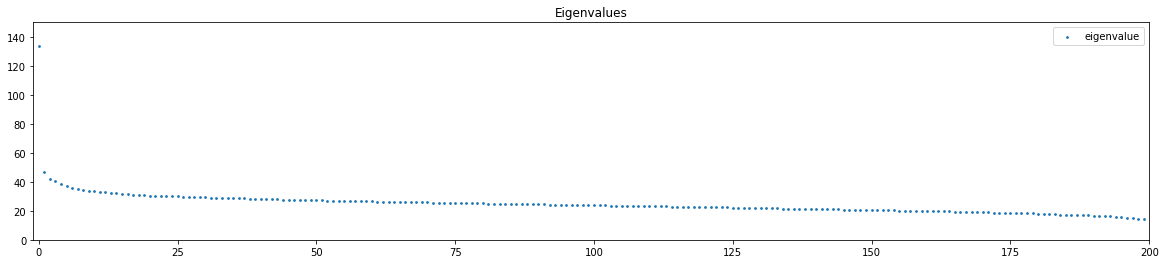

In [ ]:
# plot eigenvalues

plt.figure(figsize=(20,4))
plt.scatter(x=np.arange(0,200,1),y=sigma.tolist(),s=3,label='eigenvalue')
plt.title('Eigenvalues')
plt.legend(loc='upper right')
plt.axis([-1,200,0,150])

In [ ]:
# we have to weight words and docs in the LSA space
# @ is the python symbol to perform a matrix product (* is the operator for element wise multiplication)
# we could also use np.matmul(u,np.diag(sigma))

lsa_words = u @ np.diag(sigma)
lsa_docs = vt @ np.diag(sigma)

In [ ]:
# we put lsa_words and lsa_docs into dataframes

# lsa_docs (topics,documents)
lsa_docs = pd.DataFrame(data=lsa_docs,index=[i for i in range(200)],columns=all_books.index)

# lsa_words (words,topics)
lsa_words = pd.DataFrame(lsa_words,index=word_list,columns=[i for i in range(200)])

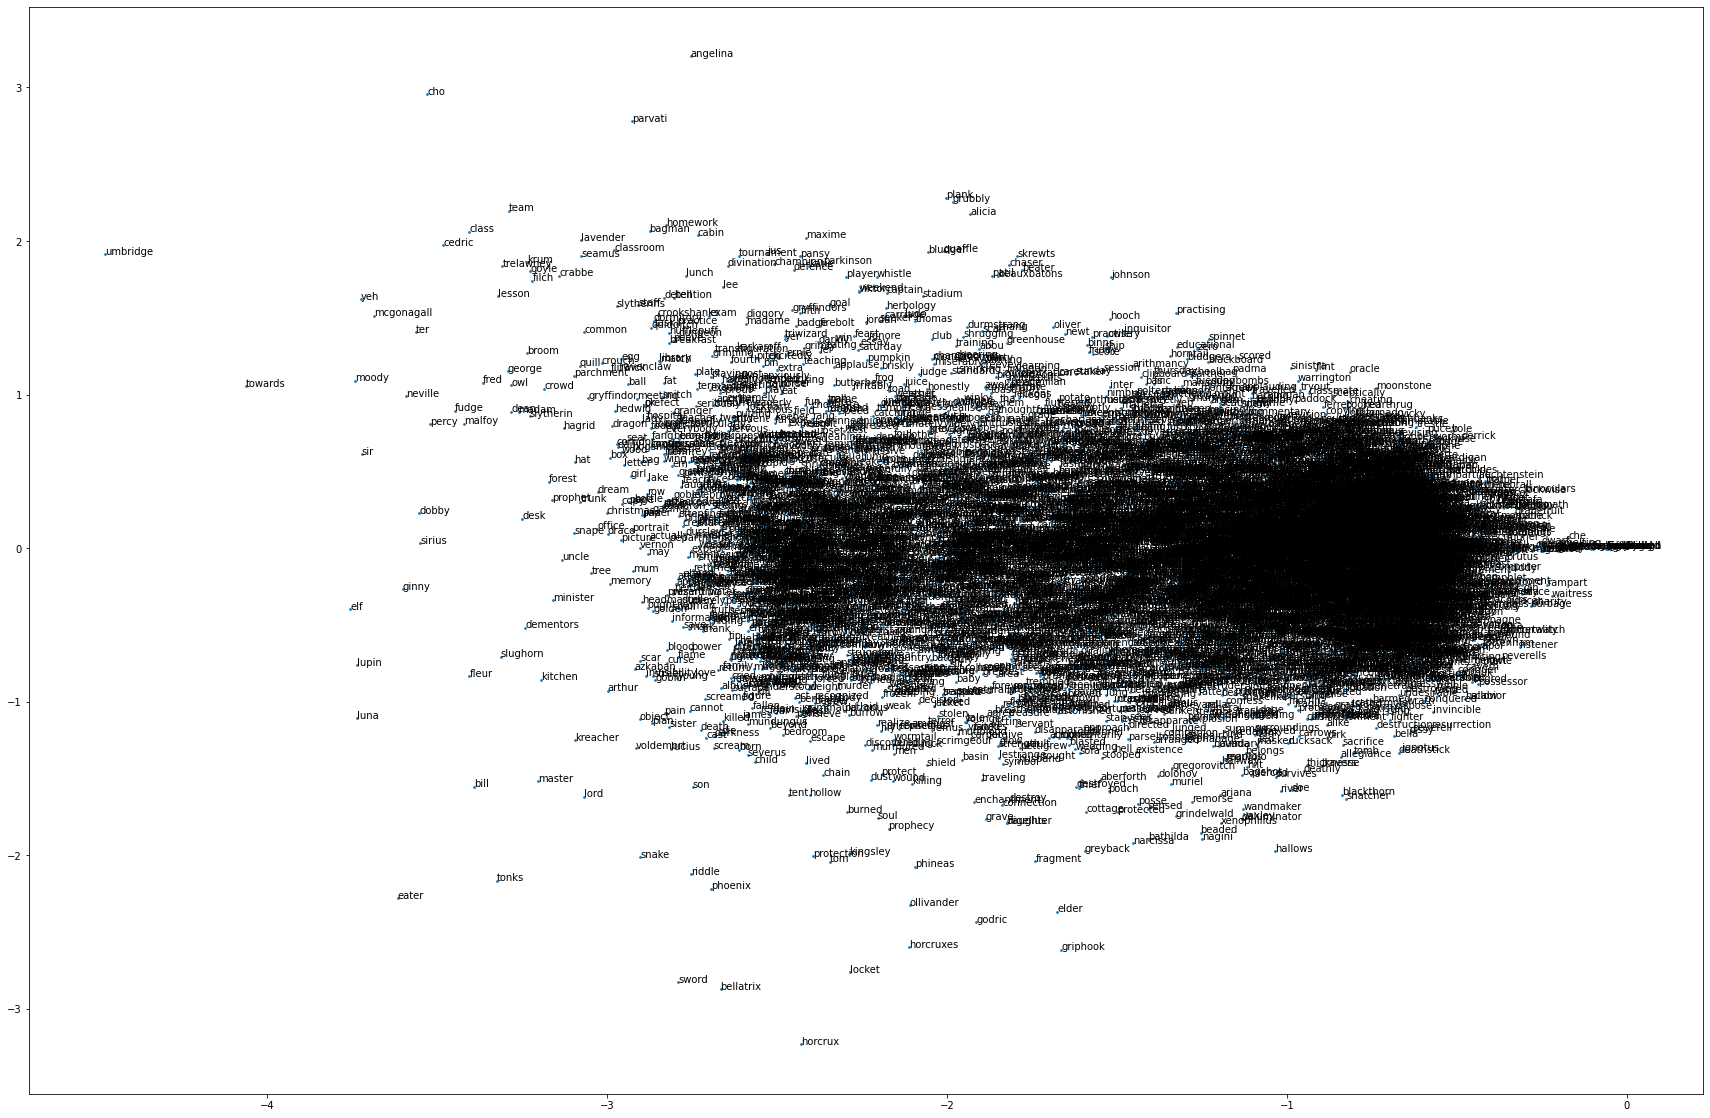

In [ ]:
# plot words in the 1st and 2nd dimension of the LSA space
plot_graph(lsa_words)

Words are all packed, we cannot use the 1st and 2nd dimension to plot because the first one is prevalent over the second.  
The first dimension is too much weighted compared to others.


In [ ]:
print(f' first eigenvalue : {sigma[0]}   -     second eigenvalue : {sigma[1]}')

 first eigenvalue : 133.88363442452336   -     second eigenvalue : 46.810923583932514


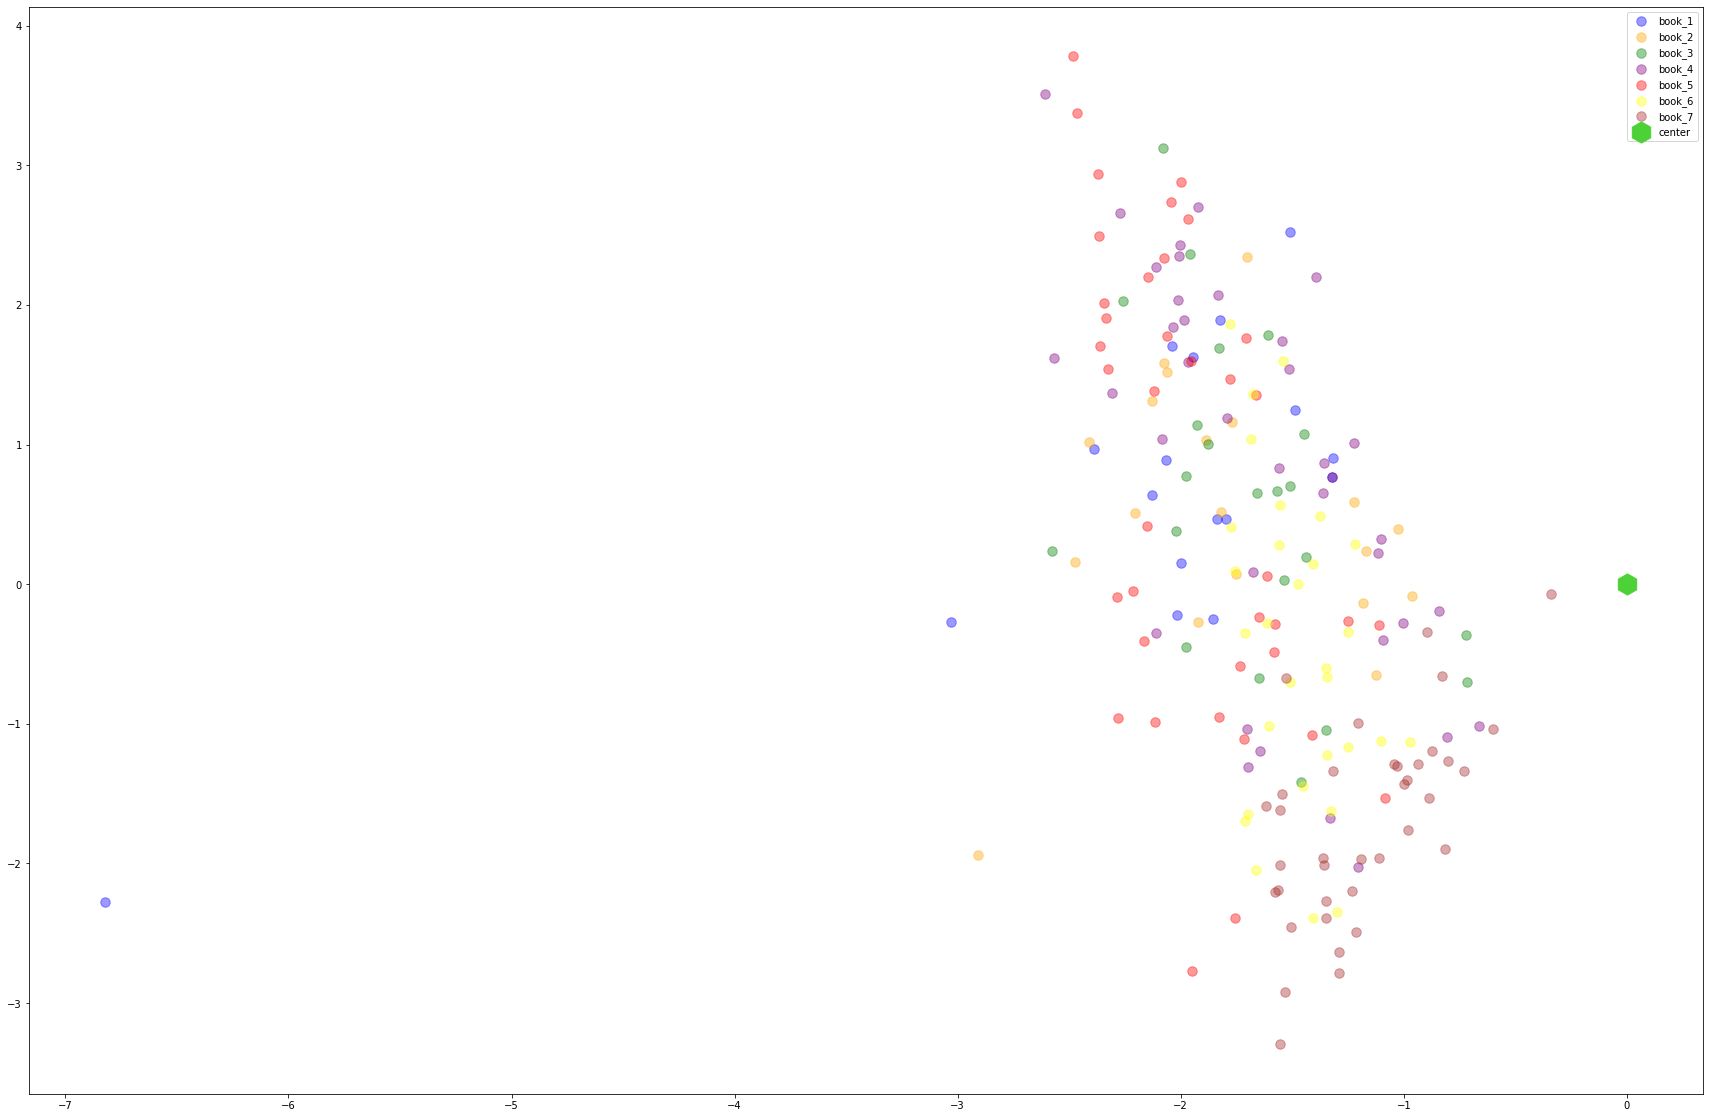

In [ ]:
# plot books in the 1st and 2nd dimension of the LSA space
plot_graph(lsa_docs.T,mode='books')

We need to normalize documents and words

In [ ]:
# compute norm 

word_norm = np.linalg.norm(lsa_words,ord=2,axis=1)
doc_norm = np.linalg.norm(lsa_docs,ord=2,axis=0)

We have 200 documents but more than 10 000 words. That is a bit too much, we will only consider words with highest norm

In [ ]:
# select only words with norm > 5.5

lsa_words_reduced = lsa_words[word_norm > 5.5]
print(f" we will consider {lsa_words_reduced.shape[0]} words")

 we will consider 353 words


In [ ]:
# normalization

lsa_words_reduced_normalized = lsa_words_reduced.div(word_norm[word_norm > 5.5],axis=0)
lsa_docs_normalized = lsa_docs.div(doc_norm,axis=1)

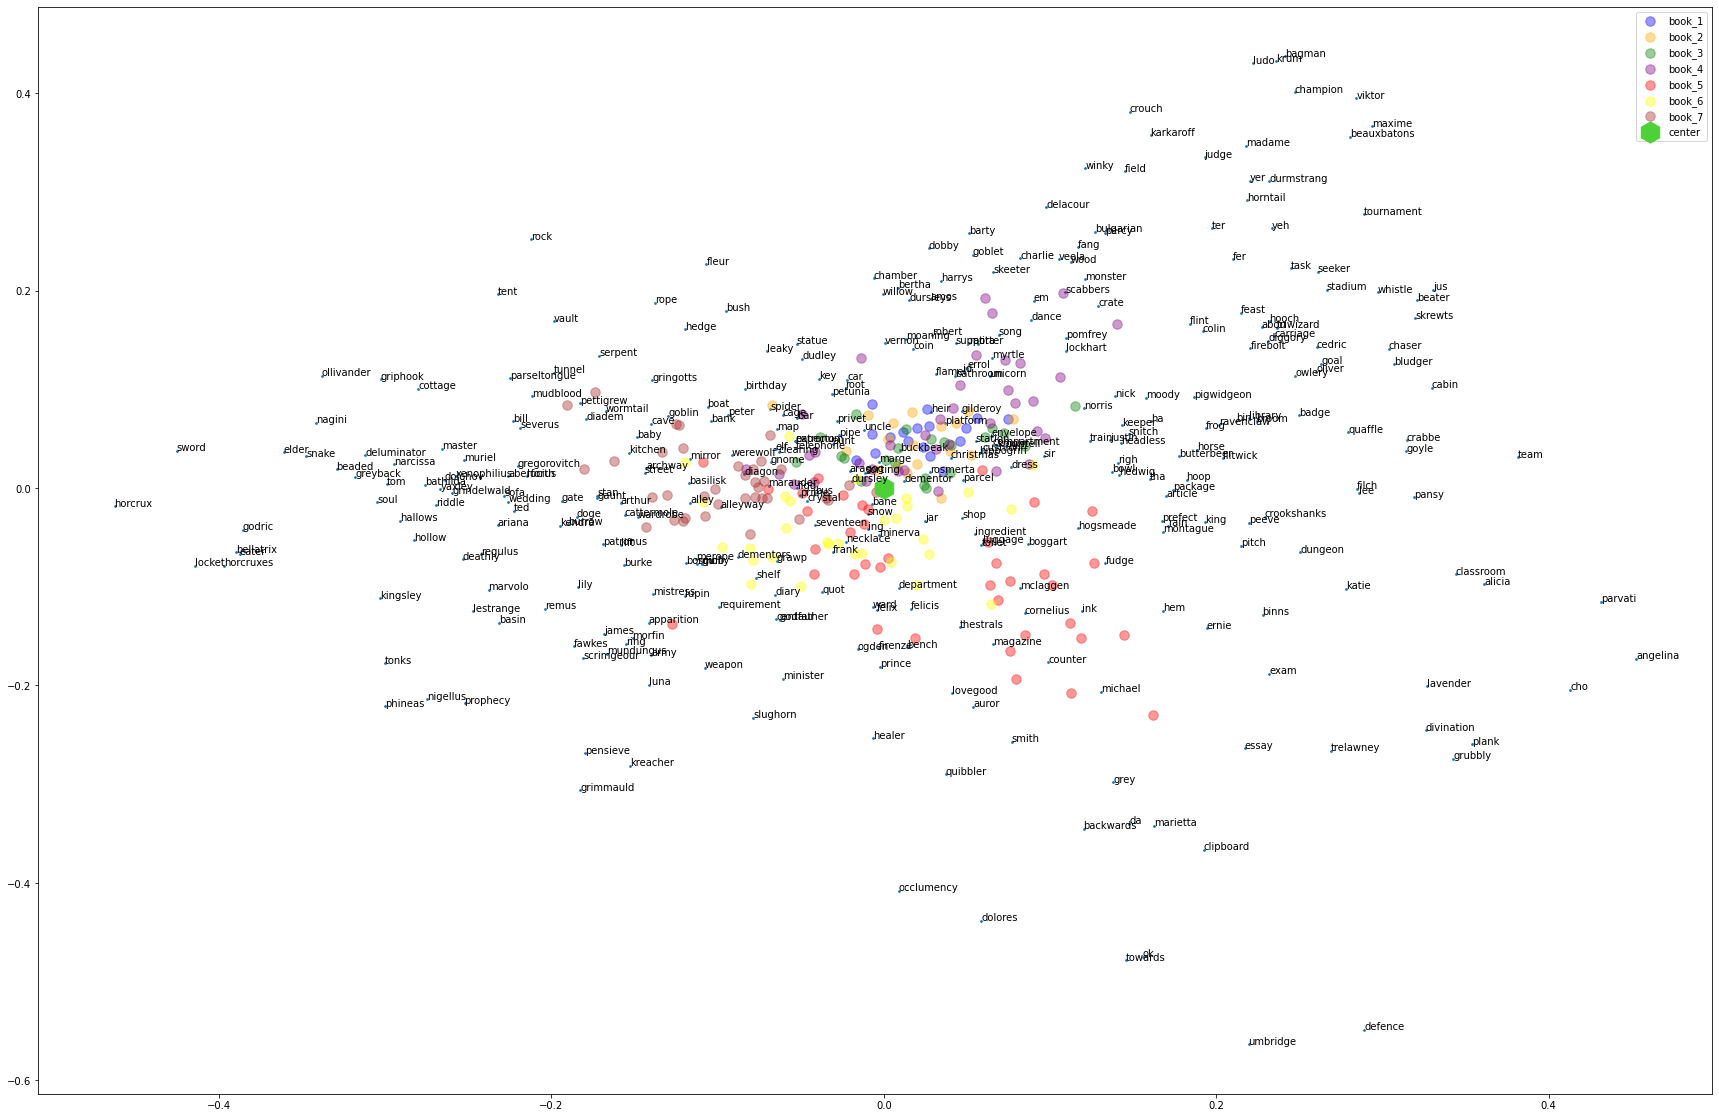

In [ ]:
plot_graph(df=[lsa_words_reduced_normalized,lsa_docs_normalized.T],mode='all',dim=(1,2))

We want to know if the word `umbridge` is related to the book 5

---



In [ ]:
def is_related(word,book,alpha=0.05,verbose=True):
  """
  chi-square test between a word and a book
  """
  docs = 200
  docs_with_book = len(all_books.loc[book,:].index)
  docs_with_word = term_doc_matrix.T.loc[word,:][(term_doc_matrix.T.loc[word,:] > 0)]
  dww = docs_with_word.shape[0]
  if book in docs_with_word.index.unique(level='Book'):
    docs_with_word_with_book = docs_with_word.loc[book,:].shape[0]
  else:
    docs_with_word_with_book = 0

  yw_yb = docs_with_word_with_book
  yw_nb = dww - yw_yb
  nw_yb = docs_with_book - yw_yb
  nw_nb = docs - dww
  observed = np.array([yw_yb,yw_nb,nw_yb,nw_nb]).reshape((2,2))
  chi2,p,dof,expected = chi2_contingency(observed)
  if verbose:
    print(f'p-value is : {p} degree of freedom : {dof}')
  if p < alpha:
    print(f'{word} is correlated to book_{book} - STATUS : dependent')
  else:
    print(f'{word} is not correlated to book_{book} - STATUS : independent')
  if verbose:
    print('observed : ')
    print(observed)
    print('expected : ')
    print(expected)

In [ ]:
for book in books:
  is_related('umbridge',book,verbose=False)

umbridge is not correlated to book_1 - STATUS : independent
umbridge is not correlated to book_2 - STATUS : independent
umbridge is correlated to book_3 - STATUS : dependent
umbridge is correlated to book_4 - STATUS : dependent
umbridge is correlated to book_5 - STATUS : dependent
umbridge is not correlated to book_6 - STATUS : independent
umbridge is not correlated to book_7 - STATUS : independent


Umbridge is not in the book 3 nor 4. It is maybe because she works in the ministerium of magic and these books are highly correlated with it.

In [ ]:
# print (word, (cosine,norm))
# print the closer words to 'umbridge' in the LSA space across the dimension 1 and 2

cosine_similarity(lsa_words_reduced,'umbridge',dim=(1,2))[:20]

[('umbridge', (0.9999999999999999, 5.272370378209211)),
 ('magazine', (0.9997404116268852, 0.9452596934017934)),
 ('backwards', (0.9993462125752853, 2.074208170989933)),
 ('da', (0.9992639731390145, 2.1927994481786732)),
 ('ok', (0.998519960199289, 2.9787326884212955)),
 ('thestrals', (0.9983841729453338, 0.856724120337705)),
 ('grey', (0.9980529032977827, 1.8155677143578373)),
 ('marietta', (0.9973923527906249, 2.127996758879393)),
 ('towards', (0.9971230628238753, 3.6202088804705204)),
 ('smith', (0.9967596292218169, 1.5728226545077804)),
 ('clipboard', (0.9936610540362754, 2.3980874992044523)),
 ('defence', (0.9935589355352203, 3.8873055958133844)),
 ('auror', (0.9910568318024429, 1.2740933587672785)),
 ('counter', (0.9901988447527976, 1.1400759632542257)),
 ('lovegood', (0.9843377240022367, 1.2427501385863902)),
 ('michael', (0.9815983852233878, 1.3433268980161002)),
 ('cornelius', (0.9764438746260317, 0.873178233809554)),
 ('felicis', (0.971854168222575, 0.6812776415498139)),
 ('d

We will add the word `defence` to the query, because it is semantically similar to `umbridge` (and has the highest norm).

Let's verify that this word is related to book 5

In [ ]:
for book in books:
  is_related('defence',book,verbose=False)

defence is not correlated to book_1 - STATUS : independent
defence is not correlated to book_2 - STATUS : independent
defence is not correlated to book_3 - STATUS : independent
defence is not correlated to book_4 - STATUS : independent
defence is correlated to book_5 - STATUS : dependent
defence is not correlated to book_6 - STATUS : independent
defence is not correlated to book_7 - STATUS : independent


In [ ]:
def _tfidf(s):
  for index,value in s.iteritems():
    if value!=0:
      w = idx_to_word[index]
      d = term_doc_matrix.T.loc[w,:][(term_doc_matrix.T.loc[w,:] > 0)]
      s[index] = (1+np.log10(value))*np.log10(200/d.shape[0])
  return s

def make_query(*args,dim=None,text=False):
  """
  we query docs that contains similarities with args
  we turn the query into a doc
  """
  query = np.zeros((len(word_list),1))
  for w in args:
    query[word_to_idx[w]] = 1.0
  query = pd.Series(query.reshape(-1))
  query = _tfidf(query)
  lsa_query = np.linalg.inv(np.diag(sigma)).dot(u.T).dot(query.to_numpy())
  lsa_query = lsa_query.T.dot(np.diag(sigma)) # we have to weight our new doc with the eigenvalues
  if dim:
    similarities = cosine_doc(lsa_docs.T,lsa_query,dim=dim,text=text)
  else:
    similarities = cosine_doc(lsa_docs.T,lsa_query,dim=dim,text=text)
  return similarities

In [ ]:
make_query('umbridge','defence',dim=(1,2))[:20]

[('book_6 chapter_15', (0.9999998733530205, 1.491671018120508)),
 ('book_5 chapter_29', (0.9999997266416144, 4.6663986413436636)),
 ('book_5 chapter_26', (0.9991103210031484, 4.070194578201672)),
 ('book_6 chapter_21', (0.9989700296963147, 1.1505022061430887)),
 ('book_5 chapter_15', (0.9942385860923174, 5.479329306809418)),
 ('book_6 chapter_9', (0.9936818577624671, 2.8278970739035496)),
 ('book_5 chapter_25', (0.991882502560505, 3.855101155031344)),
 ('book_5 chapter_28', (0.9876538745920261, 2.9649962055226213)),
 ('book_6 chapter_12', (0.986761285047554, 0.6548265880593761)),
 ('book_5 chapter_38', (0.9831074391695178, 2.549150065520166)),
 ('book_6 chapter_18', (0.9823398697913251, 2.0535455732144525)),
 ('book_5 chapter_12', (0.9750338506729833, 6.5699706276599)),
 ('book_5 chapter_27', (0.9641819773221273, 3.43458228237863)),
 ('book_6 chapter_24', (0.9638225766771172, 0.4552544088950046)),
 ('book_5 chapter_17', (0.96293119398947, 4.448839447238621)),
 ('book_5 chapter_16', (0.

In [ ]:
make_query('durmstrang','beauxbatons',dim=(1,2),text=True)[:20]

[('book_4 chapter_3',
  (0.9999950908492298,
   0.5704283852447927,
   "By the time Harry arrived in the kitchen, the three Dursleys were already seated around the table. None of them looked up as he entered or sat down. Uncle Vernon's large red face was hidden behind the morning's Daily Mail, and Aunt Petunia was cutting a grapefruit into quarters, her lips pursed over her horselike teeth. Dudley looked furious and sulky, and somehow seemed to be taking up even more space than usual. This was saying something, as he always took up an entire side of the square...")),
 ('book_2 chapter_8',
  (0.9998441274578993,
   2.367543620367928,
   '\\What are you talking about, Harry? Perhaps you\'re getting a litde drowsy? Great Scott - look at the time! We\'ve been here nearly four hours! Id never have believed it - the time\'s flown, hasn\'t it?\\" Harry didn\'t answer. He was straining his ears to hear the voice again, but there was no sound now except for Lockhart telling him he mustn\'t expe

So far we worked only with dimension 1 and 2 of the LSA space.  
Now we will choose an LSA space with more size and therefore less loss of information.  
To choose the correct rank, we apply the low rank approximation method:

>*Given a matrix C, MxN, with rank r, we wish to find an MxN matrix Ck, so as to minimize the frobenius norm of the matrix difference X = C - Ck*





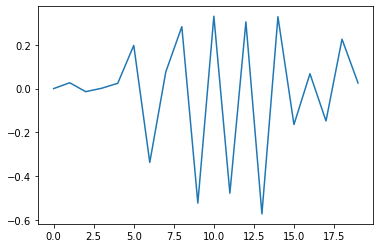

In [ ]:
def diff(s):
  result = s[1:len(s)] - s[:len(s)-1]
  return result

s = diff(sigma)
sq = diff(s)
skcurv = sq[:20] / (1+s[:20]**2)**1.5
plt.plot(np.arange(0,20,1),skcurv)

the first local minimum is 6, so we select the first 6 dimensions of the LSA space

In [ ]:
make_query('umbridge','defence',dim=(1,6),text=True)[:20]

[('book_5 chapter_29',
  (0.9665312709631263,
   4.978761270443866,
   "Careers Advice 'But why haven't you got Occlumency lessons any more?' said Hermione, frowning. 'I've told you,' Harry muttered. 'Snape reckons I can carry on by myself now I've got the basics.' 'So you've stopped having funny dreams?' said Hermione sceptically. 'Pretty much,' said Harry, not looking at her. 'Well, I don't think Snape should stop until you're absolutely sure you can control them!' said Hermione indignantly. 'Harry, I think you should go back to him and ask - ' 'No,' said Harry...")),
 ('book_5 chapter_17',
  (0.9461992787700932,
   4.776850629535358,
   'Educational DecreeNumber Twenty-fourHarry felt happier for the rest of the weekend than he had done all term. He and Ron spent much of Sunday catching up with all their homework again, and although this could hardly be called fun, the last burst of autumn sunshine persisted, so rather than sitting hunched over tables in the common room they took the

In [ ]:
# we have better result
make_query('durmstrang','beauxbatons',dim=(1,6),text=True)[:20]

[('book_4 chapter_18',
  (0.9891117740464719,
   5.516056318380809,
   "When Harry woke up on Sunday morning, it took him a moment to remember why he felt so miserable and worried. Then the memory of the previous night rolled over him. He sat up and ripped back the curtains of his own four-poster, intending to talk to Ron, to force Ron to believe him - only to find that Ron's bed was empty; he had obviously gone down to breakfast. Harry dressed and went down the spiral staircase into the common room. The moment he appeared, the people who had already finished...")),
 ('book_4 chapter_23',
  (0.9808599019028647,
   8.045081590578269,
   'Despite the very heavy load of homework that the fourth years had been given for the holidays. Harry was in no mood to work when term ended, and spent the week leading up to Christmas enjoying himself as fully as possible along with everyone else. Gryffindor Tower was hardly less crowded now than during term-time; it seemed to have shrunk slightly too, 

There are others methods to represent words and docs (called topic modelling) than LSA:
* LDA (Latent dirichlet allocution)
* pLSA
* lda2Vec (deep learning approach)


# Glove embedding

In [ ]:
!pip install glove_python

In [ ]:
def create_corpus(df):
  texts = df['Text'].apply(lambda x:preprocess_pipeline(x,remove_dot=False))
  corpora = []
  for index,row in texts.iteritems():
    text = row.split('.')
    for t in text:
      seq = t.split()
      corpora.append(seq)
  corpora = list(filter(lambda x:x!=[],corpora))
  return corpora

In [ ]:
texts = create_corpus(all_books)

In [ ]:
from glove import Corpus, Glove

if os.path.exists('glove.model'):
  glove = Glove.load('glove.model')
else:
  corpus = Corpus() 
  texts = create_corpus(all_books)

  # Training the corpus to generate the co occurence matrix which is used in GloVe
  corpus.fit(texts,window=5)

  glove = Glove(no_components=100, learning_rate=0.01) 
  glove.fit(corpus.matrix, epochs=50 ,no_threads=4, verbose=False)
  glove.add_dictionary(corpus.dictionary)
  glove.save('glove.model')

In [ ]:
len(glove.dictionary)

19979

In [ ]:
glove.most_similar('ron',number=10)

[('hermione', 0.9295751842552826),
 ('whispered', 0.8161153320575558),
 ('asked', 0.8122656613806852),
 ('muttered', 0.8113719228051667),
 ('demanded', 0.8112154027619535),
 ('ginny', 0.8092797336543655),
 ('gasped', 0.7749832387244753),
 ('ignoring', 0.7714929698436278),
 ('snapped', 0.7653803627510098)]

## Word2Vec

In [ ]:
from gensim.models import Word2Vec

if os.path.exists('word2vec.model'):
  word2vec = Word2Vec.load('word2vec.model')
else:
  word2vec = Word2Vec(sentences=texts, min_count=5,workers=4,window=5)
  # summarize the loaded model
  print(word2vec)
  word2vec.train(sentences=texts,epochs=50,total_examples=word2vec.corpus_count)
  word2vec.save("word2vec.model")

In [ ]:
word2vec.most_similar('beauxbatons')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('durmstrang', 0.6321072578430176),
 ('madame', 0.5211794376373291),
 ('ship', 0.49422165751457214),
 ('group', 0.48541367053985596),
 ('milling', 0.4801329970359802),
 ('maxime', 0.44099581241607666),
 ('delegation', 0.4325973391532898),
 ('filed', 0.43237313628196716),
 ('descending', 0.42891526222229004),
 ('paddock', 0.4202500879764557)]

In [ ]:
word2vec.wv.similar_by_word('ron')

[('hermione', 0.6591438055038452),
 ('harry', 0.6397386193275452),
 ('ginny', 0.558914303779602),
 ('ok', 0.5534013509750366),
 ('crookshanks', 0.5177880525588989),
 ('mon', 0.4676835536956787),
 ('neville', 0.43252506852149963),
 ('breakfast', 0.4295860826969147),
 ('hastily', 0.42414867877960205),
 ('mindedly', 0.41405490040779114)]

In [ ]:
word2vec.wv.similar_by_word('harry')

[('ron', 0.6397386789321899),
 ('hermione', 0.5504641532897949),
 ('cho', 0.4329022467136383),
 ('lupin', 0.41868484020233154),
 ('ginny', 0.40881776809692383),
 ('snape', 0.40788087248802185),
 ('back', 0.3930965065956116),
 ('neville', 0.3831077814102173),
 ('cedric', 0.38096022605895996),
 ('moody', 0.38088279962539673)]

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE    # final reduction


def reduce_dimensions(model):
  num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
  vectors = np.asarray(model.wv.vectors)
  labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings

    # reduce using t-SNE
  tsne = TSNE(n_components=num_dimensions, random_state=0)
  vectors = tsne.fit_transform(vectors)

  x_vals = [v[0] for v in vectors]
  y_vals = [v[1] for v in vectors]
  return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(word2vec)

def plot_with_matplotlib(x_vals, y_vals, labels):
  import matplotlib.pyplot as plt
  import random

  random.seed(0)

  plt.figure(figsize=(12, 12))
  plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
  indices = list(range(len(labels)))
  selected_indices = random.sample(indices, 25)
  for i in selected_indices:
      plt.annotate(labels[i], (x_vals[i], y_vals[i]))

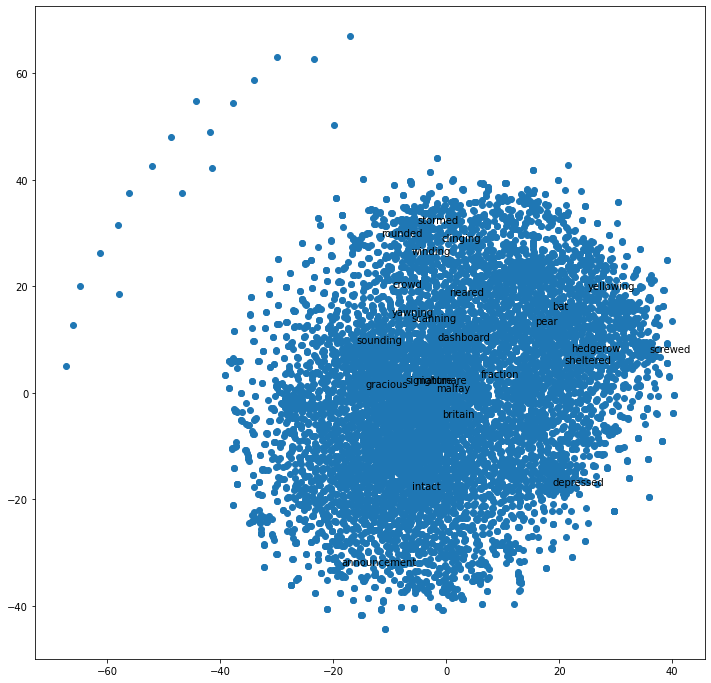

In [ ]:
plot_with_matplotlib(x_vals,y_vals,labels)

In [ ]:
!git clone https://github.com/GradySimon/tensorflow-glove.git

fatal: destination path 'tensorflow-glove' already exists and is not an empty directory.


In [ ]:
%tensorflow_version 1.5
import tf_glove

model = tf_glove.GloVeModel(embedding_size=300, context_size=10)
model.fit_to_corpus(texts)
model.train(num_epochs=100)

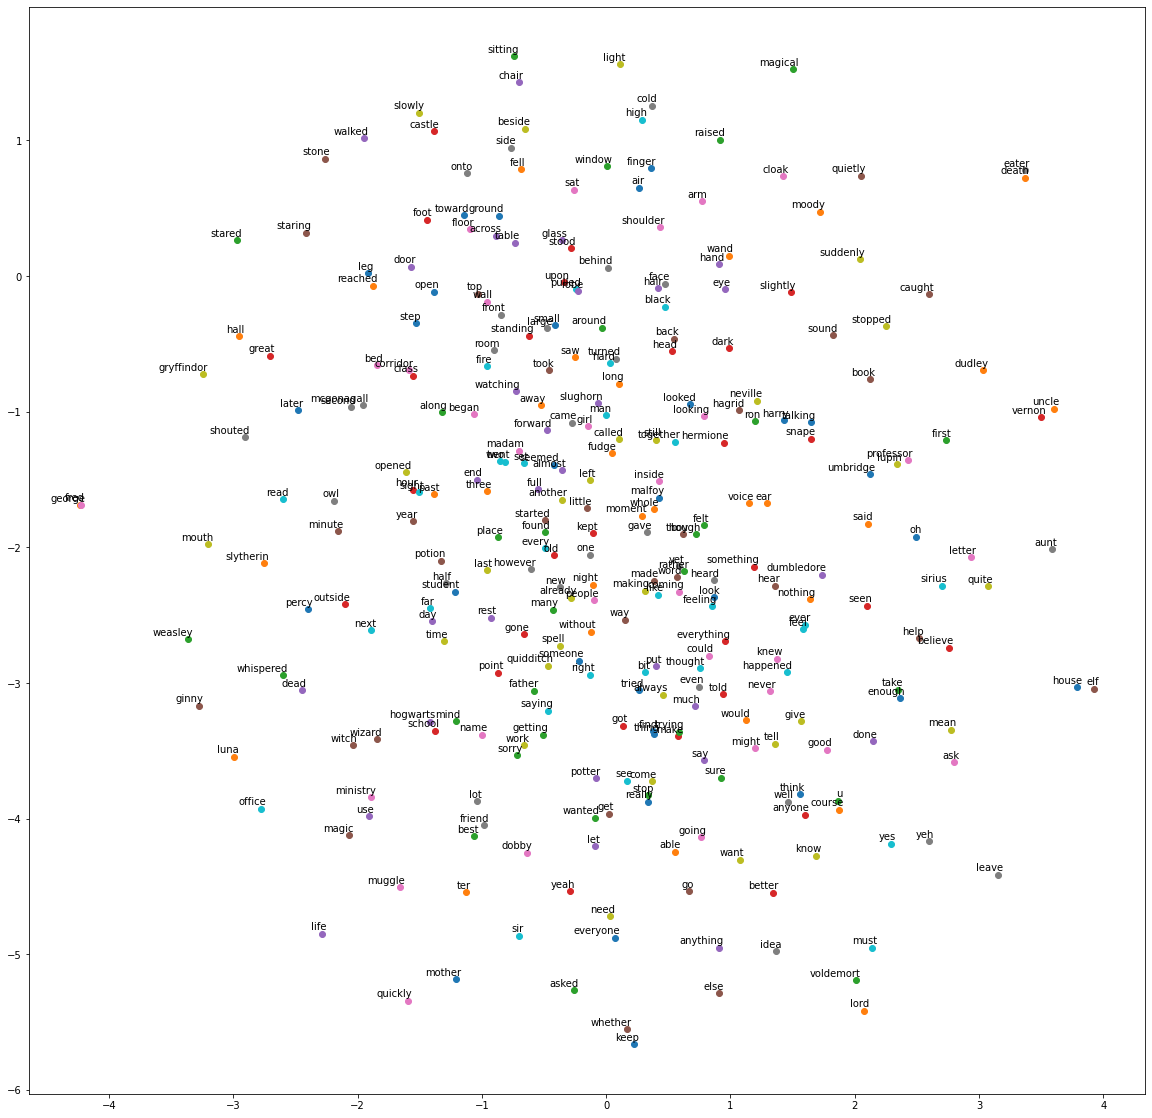

In [ ]:
model.generate_tsne(word_count=300,size=(20,20))